# Outliers in Murder Accountability Project

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from mlxtend.preprocessing import minmax_scaling

from sklearn import preprocessing
from sklearn.metrics.pairwise import cosine_similarity

import pickle as pk

from jupyterthemes import jtplot

jtplot.style(figsize=(15, 9))

## Data

In [2]:
map_data = pd.read_csv('data/SHR65_22.csv', index_col=0)
map_data.head()

,CNTYFIPS,Ori,State,Agency,Agentype,Source,Solved,Year,Month,Incident,...,OffRace,OffEthnic,Weapon,Relationship,Circumstance,Subcircum,VicCount,OffCount,FileDate,MSA
ID,,,,,,,,,,,,,,,,,,,,,
197601001AKASP00,"Juneau, AK",AKASP00,Alaska,State Troopers,Primary state LE,FBI,Yes,1976,January,1,...,American Indian or Alaskan Native,Unknown or not reported,Knife or cutting instrument,Husband,Other arguments,NaN,0,0,30180.0,Rural Alaska
197601001AL00102,"Jefferson, AL",AL00102,Alabama,Birmingham,Municipal police,FBI,Yes,1976,January,1,...,Black,Unknown or not reported,Shotgun,Acquaintance,Felon killed by private citizen,Felon killed in commission of a crime,0,0,30180.0,"Birmingham-Hoover, AL"
197601001AL00104,"Jefferson, AL",AL00104,Alabama,Fairfield,Municipal police,FBI,Yes,1976,January,1,...,Black,Unknown or not reported,Shotgun,Wife,Other,NaN,0,0,30180.0,"Birmingham-Hoover, AL"
197601001AL00106,"Jefferson, AL",AL00106,Alabama,Leeds,Municipal police,FBI,Yes,1976,January,1,...,Black,Unknown or not reported,Knife or cutting instrument,Brother,Other arguments,NaN,0,0,30180.0,"Birmingham-Hoover, AL"
197601001AL00201,"Mobile, AL",AL00201,Alabama,Mobile,Municipal police,FBI,Yes,1976,January,1,...,White,Unknown or not reported,Strangulation - hanging,Acquaintance,Circumstances undetermined,NaN,0,0,30180.0,"Mobile, AL"


In [3]:
COLORS = {
    'Sex': ['pink', 'b', 'w'],
    'Solved': ['r', 'b'],
    'Source': ['g', 'b'],
}

## Helpers

In [4]:
def get_data_by_params(params):
    data = map_data.copy()
    
    for k, v in params.items():
        if k in data.columns and v in data[k].unique():
            data = data[data[k]==v]
    
    return data


## .75 Percentile

In [120]:
def get_cases_above_75(by, data_params={}, visualize=True):
    data = get_data_by_params(data_params)
    _75 = data.groupby(by).count().quantile(q=.75)[0]
    
    data = data.groupby(by).count()['CNTYFIPS'].to_frame()
    data.rename(columns={'CNTYFIPS': 'all cases'}, inplace=True)
    
    cases_above_p75 = data[data['all cases']>_75].copy()
    cases_above_p75.rename(columns={'all cases': 'cases above p75'}, inplace=True)
    
    data['below p75'] = data['all cases']
    data.loc[data['below p75'] > _75, 'below p75'] = _75
    data['above p75'] = data['all cases'] - data['below p75']
    
    if visualize:
        visualize_outliers(data, data_params)
    
    return data, cases_above_p75


def visualize_outliers(data, title):
    if isinstance(data.index, pd.MultiIndex):
        visualize_multiindex(data, title)
        return
    
    visualize_cases_above_75(data, title)

def visualize_cases_above_75(data, title):
    fig, ax = plt.subplots(1, figsize=(21, 4))

    data['all cases'].plot(kind='area', ax=ax, color=['r'], label='Above 75%')
    data['below p75'].plot(kind='area', ax=ax, color=['b'], label='Below 75%')
    if not title:
        title = 'All cases'
    ax.set_title(title)
    
    if data.index.name != 'Year':
        x_labels = data.index.to_list()
        ax.set_xticks(np.arange(0, len(x_labels)))
        ax.set_xticklabels(x_labels, rotation=90)
    else:
        x_labels = np.arange(1976, 2023)
        ax.set_xticks(x_labels)
        ax.set_xticklabels(x_labels, rotation=45)
    
    ax.legend()


def visualize_multiindex(data, title):
    fig, ax = plt.subplots(1, figsize=(21, 21))

    x_labels = data.index.get_level_values(0).unique()
    y_labels = data.index.get_level_values(1).unique()

    ax.set_xticks(np.arange(0, len(x_labels)))
    ax.set_yticks(np.arange(0, len(y_labels)))

    ax.set_xticklabels(x_labels, rotation=90)
    ax.set_yticklabels(y_labels);

    for n, i in enumerate(data.index.get_level_values(1).unique()):
        vector = np.arange(0, data.loc[:, i, :].shape[0])
        s = data.loc[:, i, :]['above p75']>1
        s = s.astype(int)
        vector = vector[vector*s.to_list()>0]
        ax.scatter(vector, np.ones(len(vector))*n, color='w')


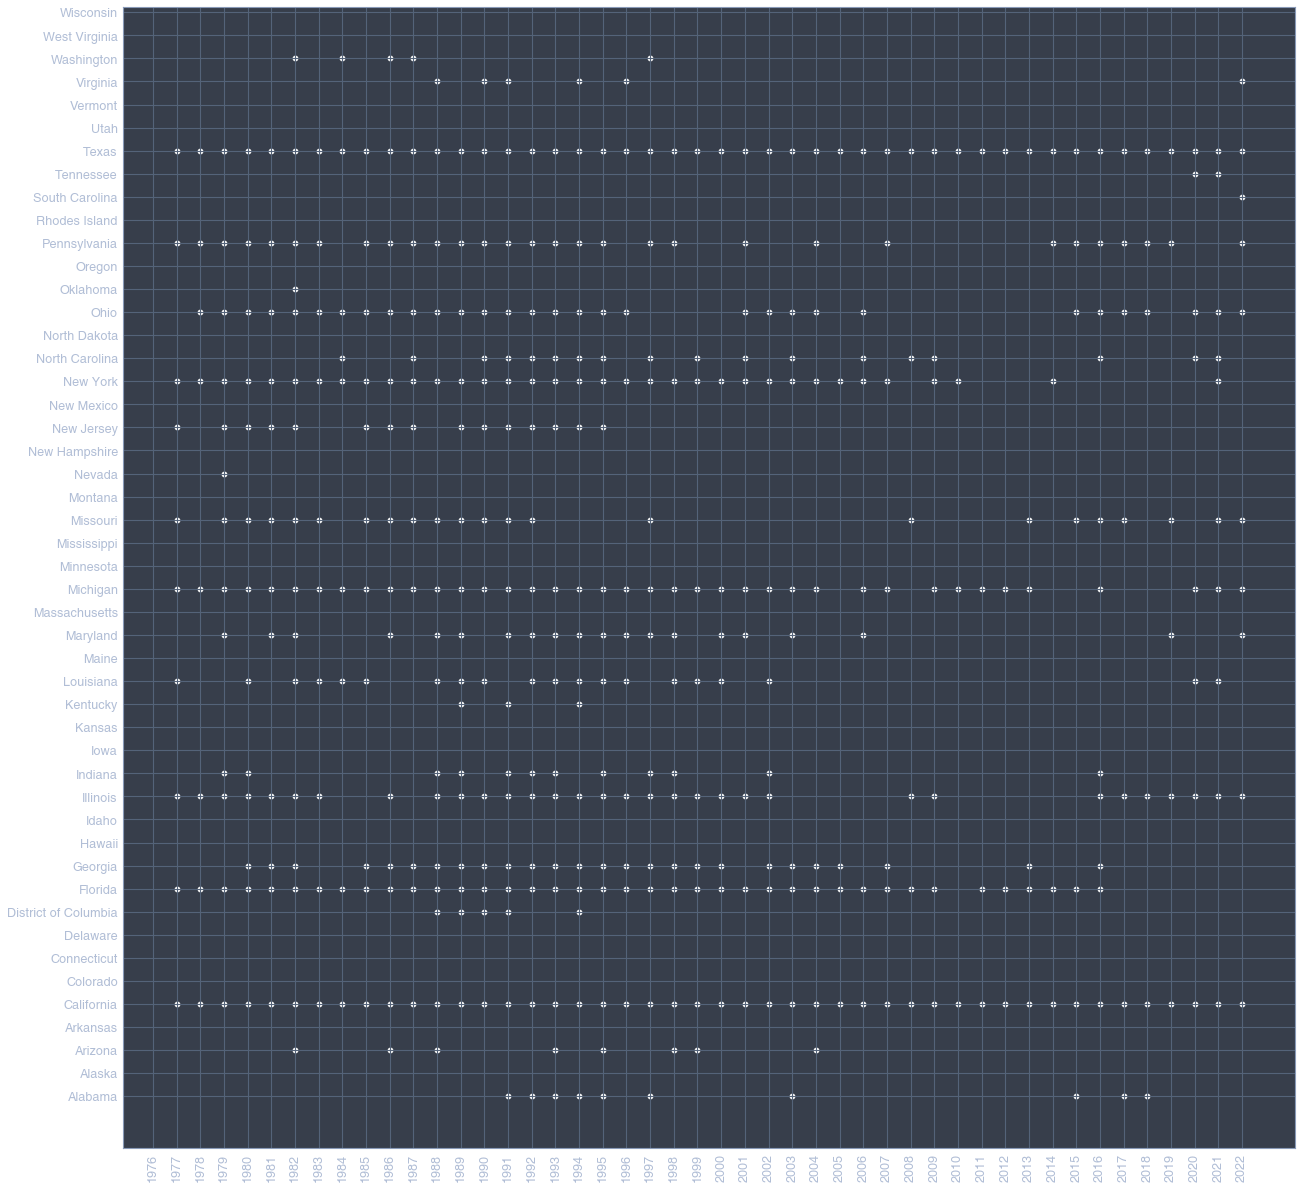

In [113]:
d, cases = get_cases_above_75(['Year', 'State'], data_params={'Solved': 'No', 'VicSex': 'Female'})

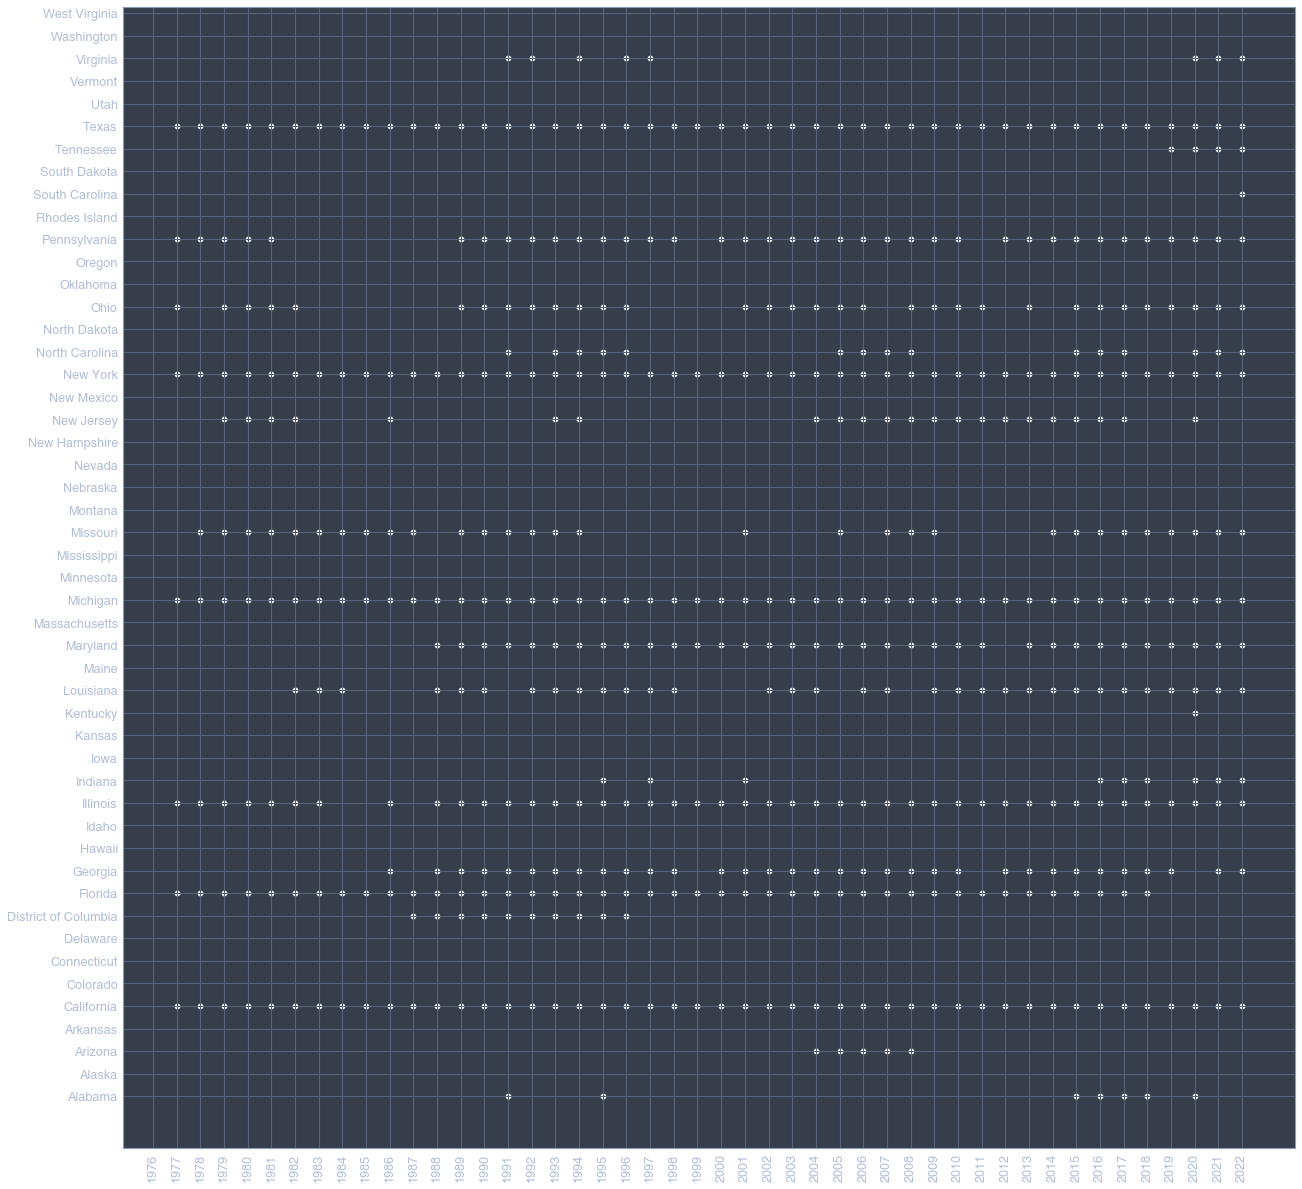

In [88]:
d, cases = get_cases_above_75(['Year', 'State'], data_params={'Solved': 'No'})

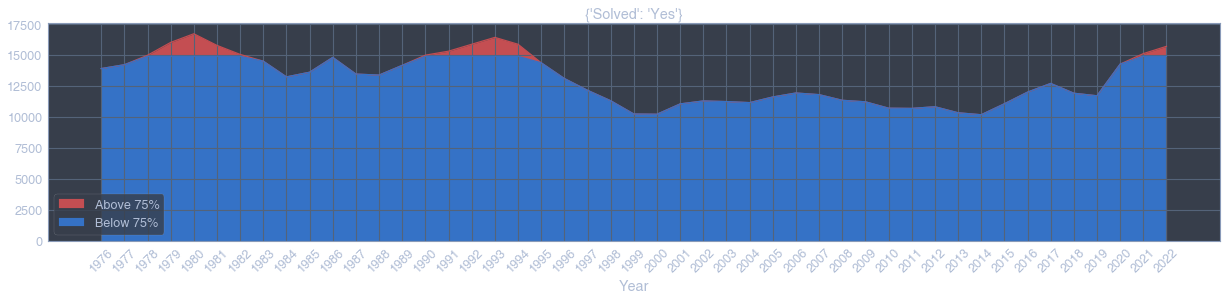

In [58]:
d, cases = get_cases_above_75('Year', data_params={'Solved': 'Yes'})

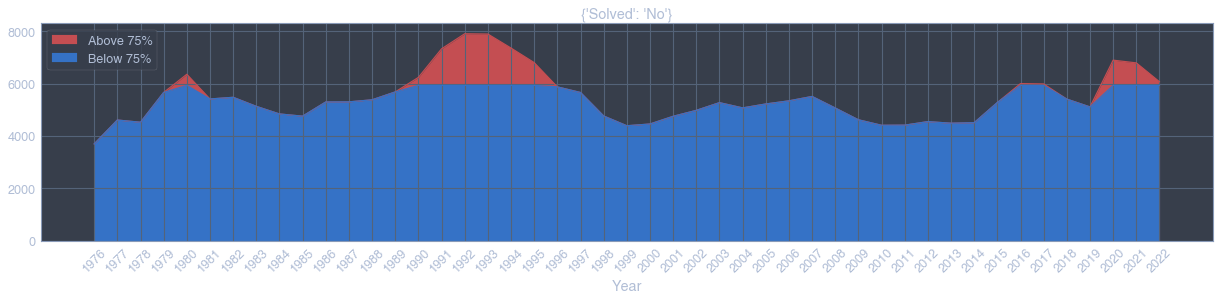

In [9]:
d, cases = get_cases_above_75('Year', data_params={'Solved': 'No'})

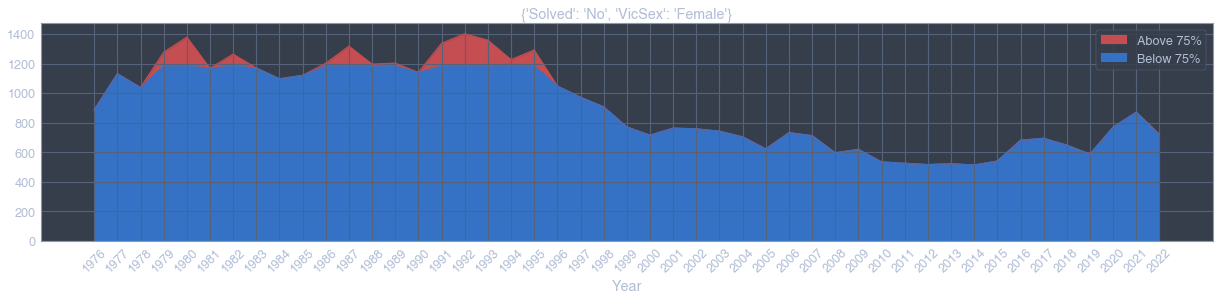

In [47]:
d, cases = get_cases_above_75('Year', data_params={'Solved': 'No', 'VicSex': 'Female'})

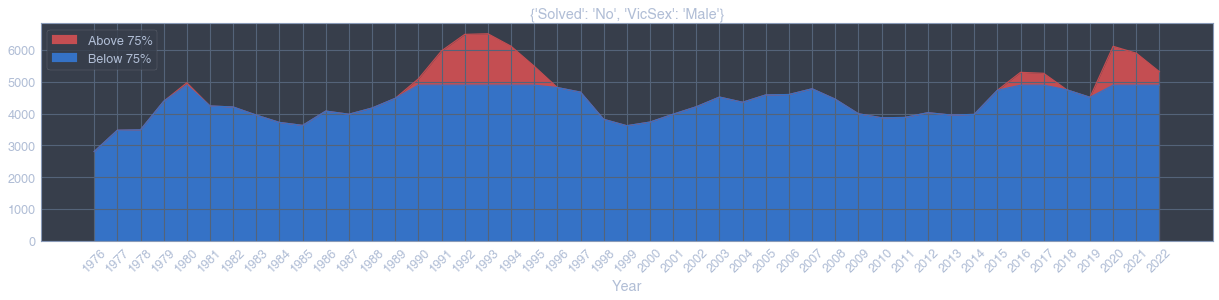

In [49]:
d, cases = get_cases_above_75('Year', data_params={'Solved': 'No', 'VicSex': 'Male'})

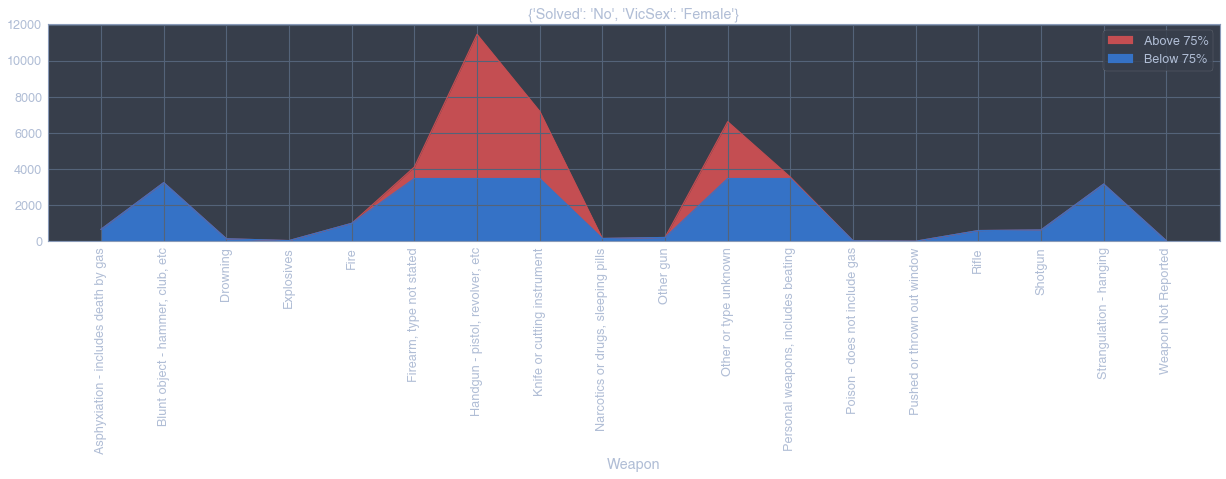

In [54]:
d, cases = get_cases_above_75('Weapon', data_params={'Solved': 'No', 'VicSex': 'Female'})

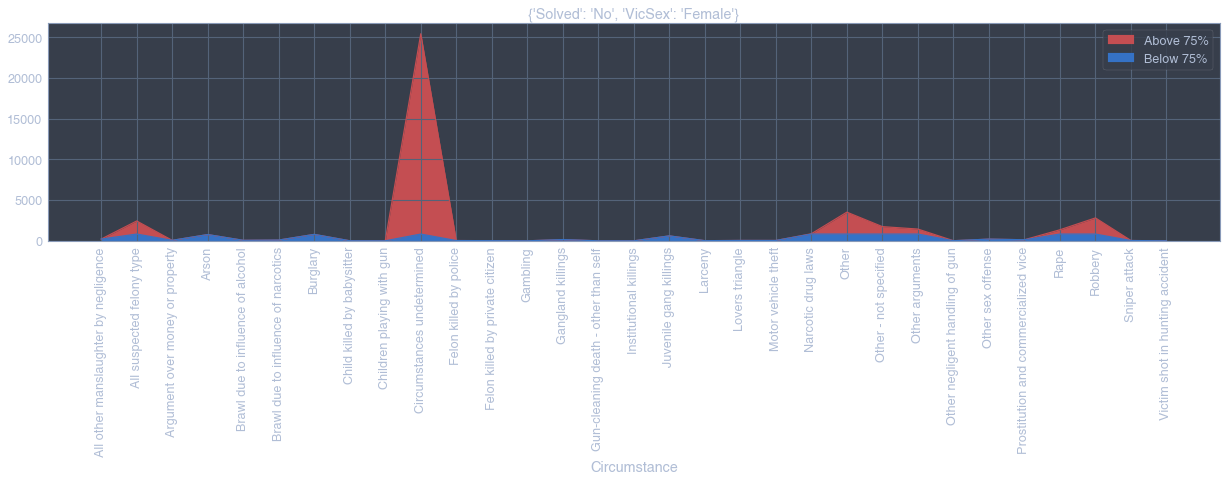

In [56]:
d, cases = get_cases_above_75('Circumstance', data_params={'Solved': 'No', 'VicSex': 'Female'})

## .75 Percentile for ratio

In [11]:
def ratio_75(feature_name, ratio=['first', 'second'], data_params={}, visualize=True):
    data = get_data_by_params(data_params)
    ratio_75 = pd.DataFrame(index=map_data['State'].unique(), columns=['Years from 75-quantile'])
    
    for state in map_data['State'].unique():
        state_data = data[(data['State']==state)]
    
        first = state_data.groupby(feature_name).count()['Ori']
        second = state_data.groupby(feature_name).count()['Ori']
        
        if ratio[0] in first.index and ratio[1] in second.index:
            first = state_data.groupby(feature_name).count()['Ori'].loc[ratio[0]]
            second = state_data.groupby(feature_name).count()['Ori'].loc[ratio[1]]

            res = state_data.groupby(['Year', feature_name]).count()['Ori'].to_frame()

            res_pv = pd.pivot_table(res, index='Year', columns=feature_name, values='Ori')

            res_pv = res_pv[[ratio[0], ratio[1]]]
            res_pv['Ratio'] = res_pv[ratio[0]] / res_pv[ratio[1]]

            ratio_75.loc[state, 'Years from 75-quantile'] = res_pv[res_pv['Ratio'] > res_pv['Ratio']\
                                                                     .quantile(q=.75)].index.to_list()
        else:
            ratio_75.loc[state, 'Years from 75-quantile'] = []
    
    ratio_75['coords'] = ratio_75['Years from 75-quantile'].apply(lambda row: [year%1976 for year in row])
    
    if visualize:
        visualize_ratio_75(ratio_75)
    
    return ratio_75


def visualize_ratio_75(ratio_75):
    fig, ax = plt.subplots(1, figsize=(21, 21))

    x_labels = np.arange(1976, 2023)
    y_labels = list(ratio_75.index)

    for i in range(1, ratio_75.shape[0]+1): 
        ax.scatter(ratio_75.iloc[i-1]['coords'],
                   np.ones(len(ratio_75.iloc[i-1]['Years from 75-quantile']))*i, color='w')

    ax.set_yticks(np.arange(1, len(y_labels)+1))
    ax.set_xticks(np.arange(0, 47))

    ax.set_xticklabels(x_labels, rotation=45)
    ax.set_yticklabels(y_labels);


### White/Black

#### Solved & Unsolved

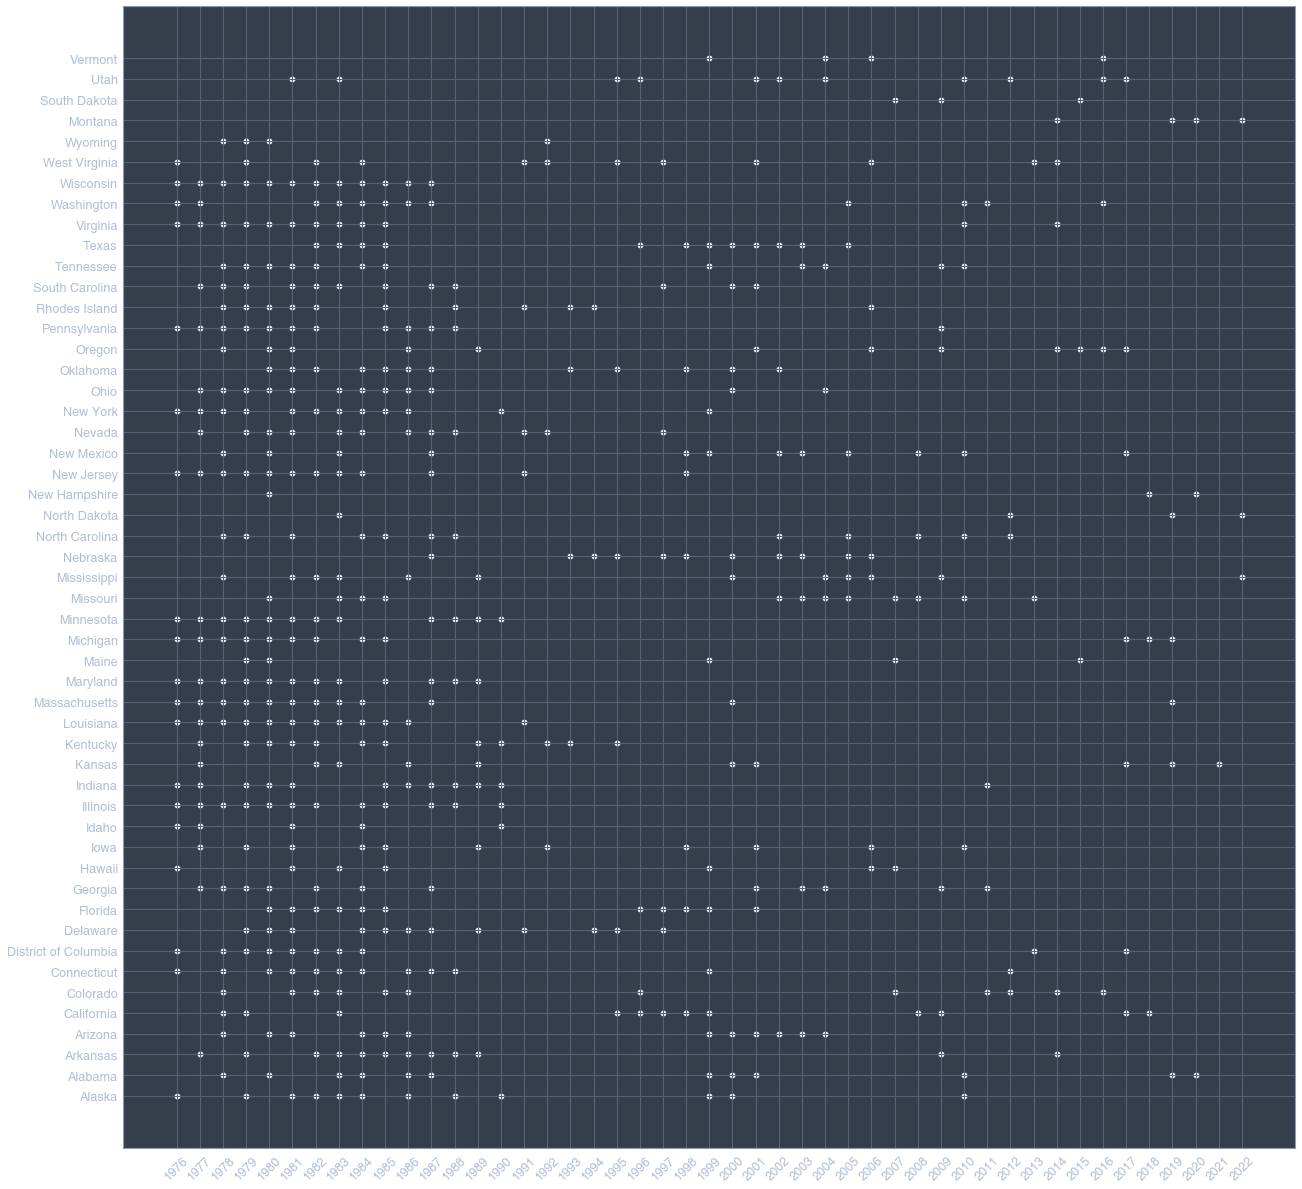

In [12]:
ratio_75_white_black = ratio_75('VicRace', ratio=['White', 'Black'])

#### Solved

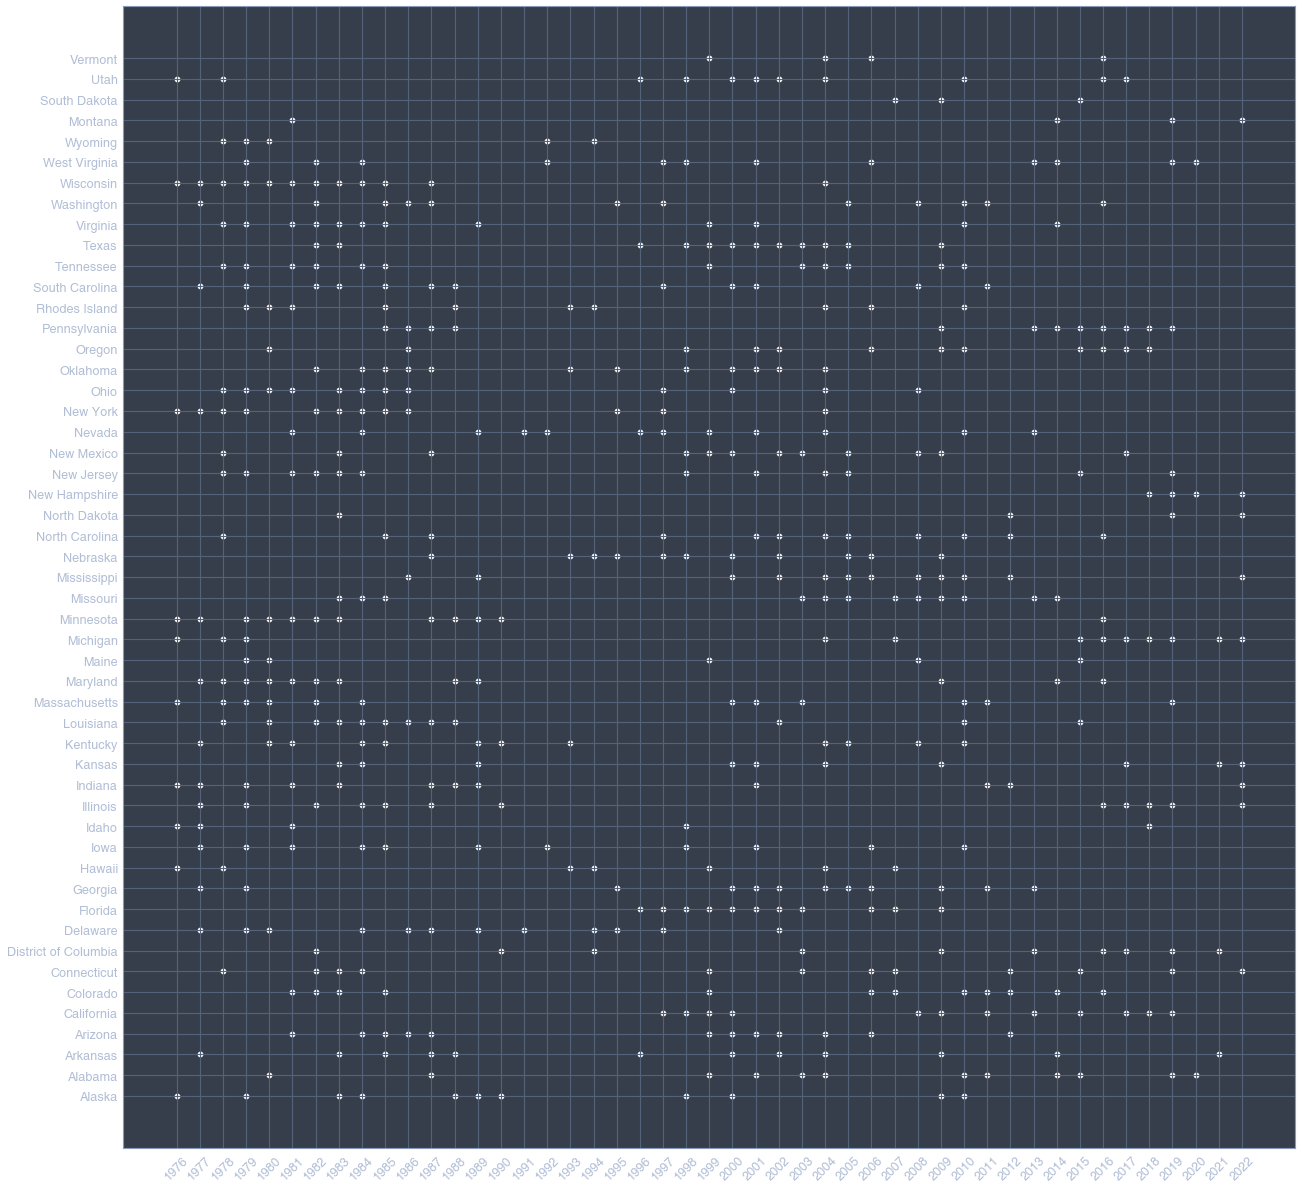

In [6]:
ratio_75_white_black_slvd = ratio_75('VicRace', ratio=['White', 'Black'], data_params={'Solved': 'Yes'})

#### Unsolved

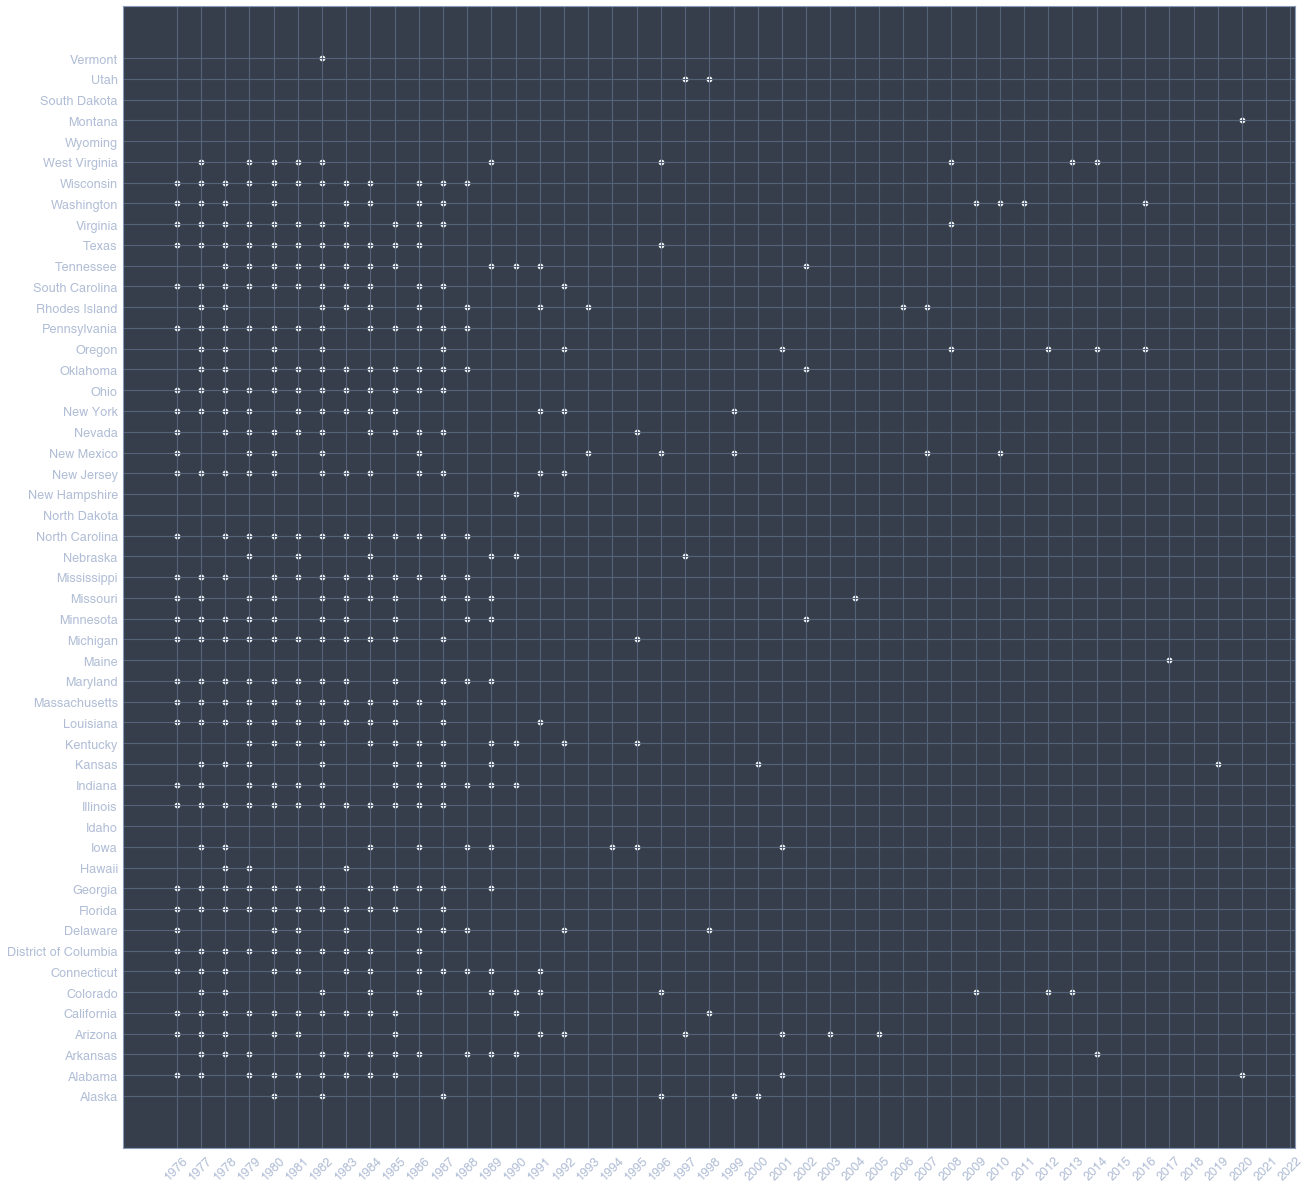

In [7]:
ratio_75_white_black_unslvd = ratio_75('VicRace', ratio=['White', 'Black'], data_params={'Solved': 'No'})

### Female/Male

#### Solved & Unsolved

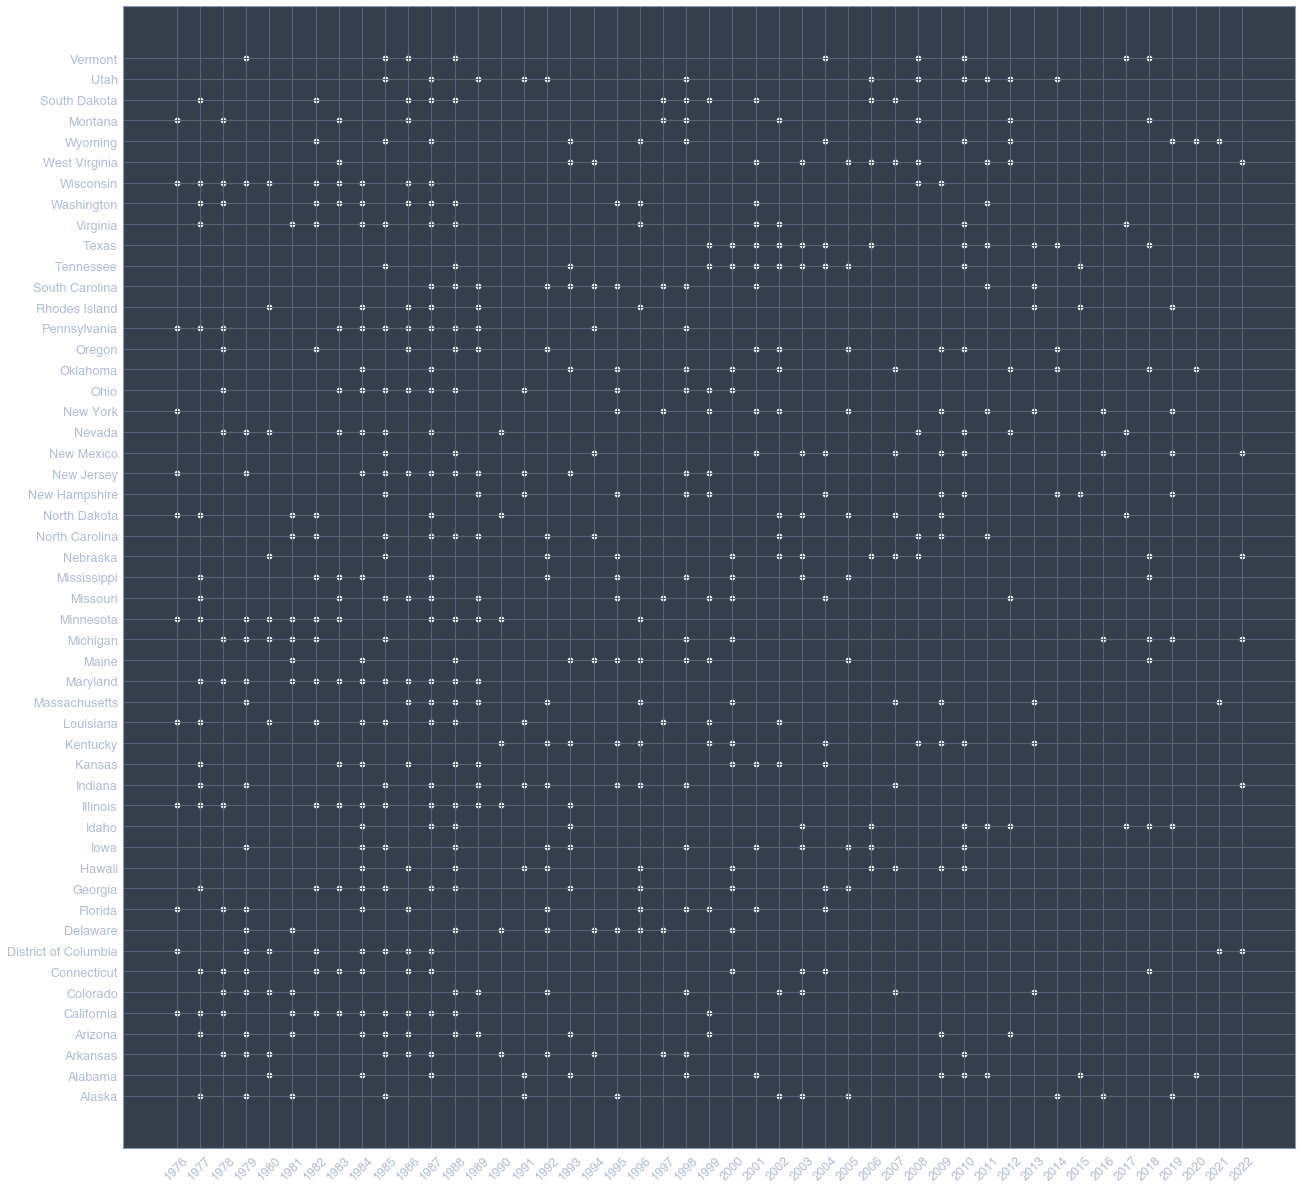

In [12]:
ratio_75_female_male = ratio_75('VicSex', ratio=['Female', 'Male'])

#### Solved

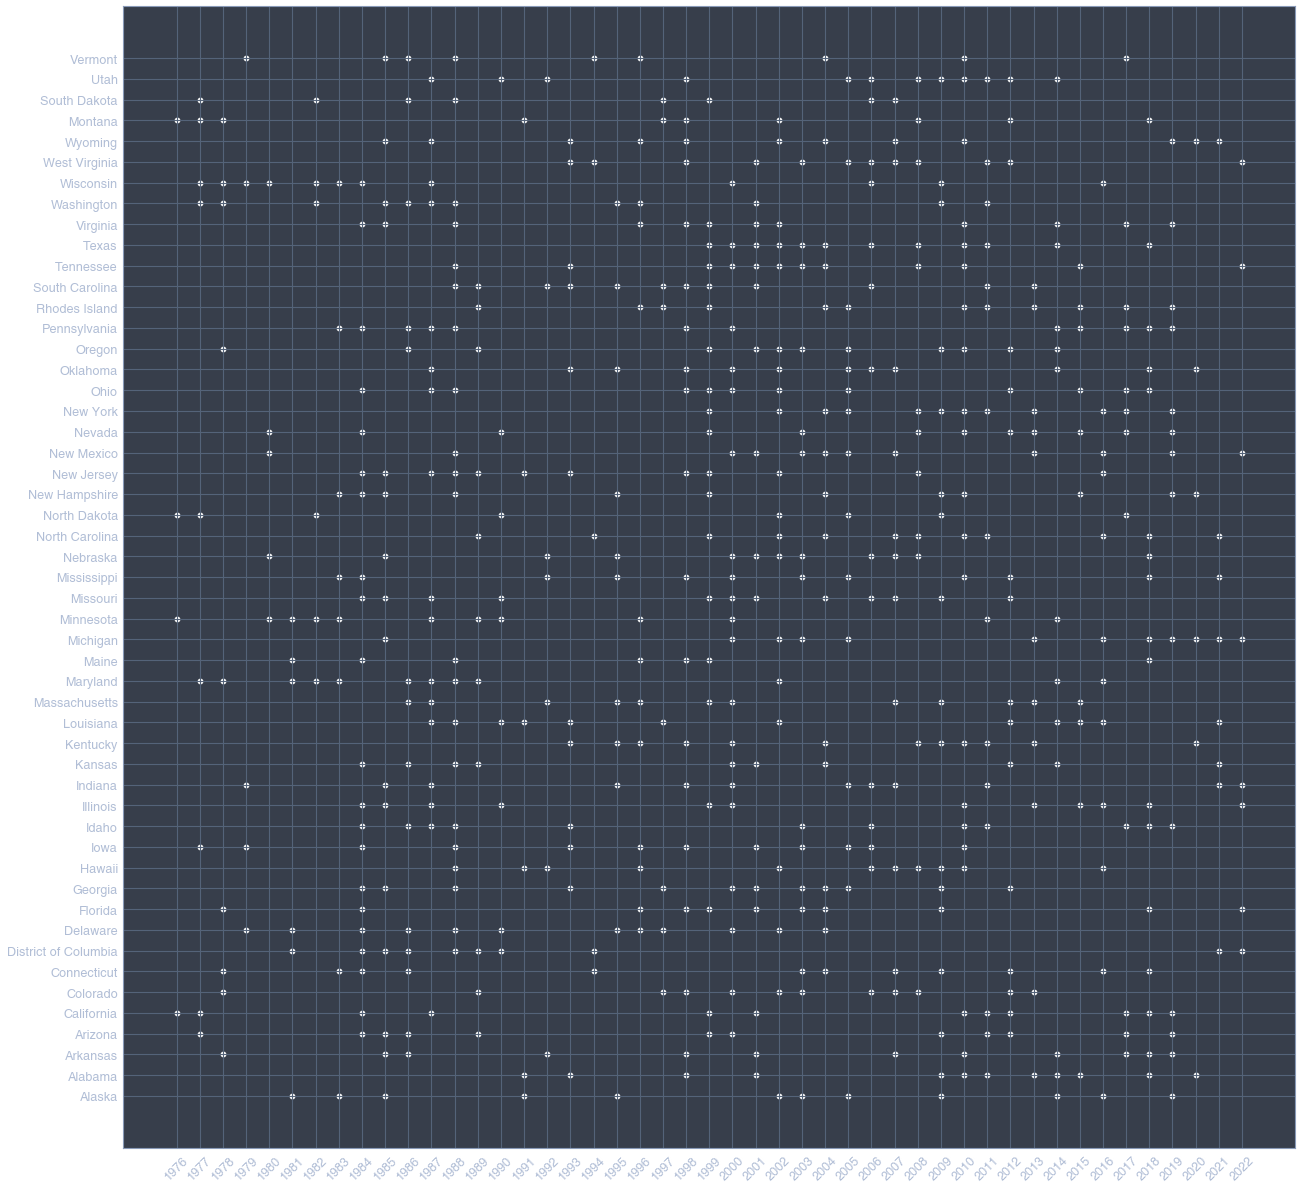

In [14]:
ratio_75_female_male_slvd = ratio_75('VicSex', ratio=['Female', 'Male'], data_params={'Solved': 'Yes'})

#### Unsolved

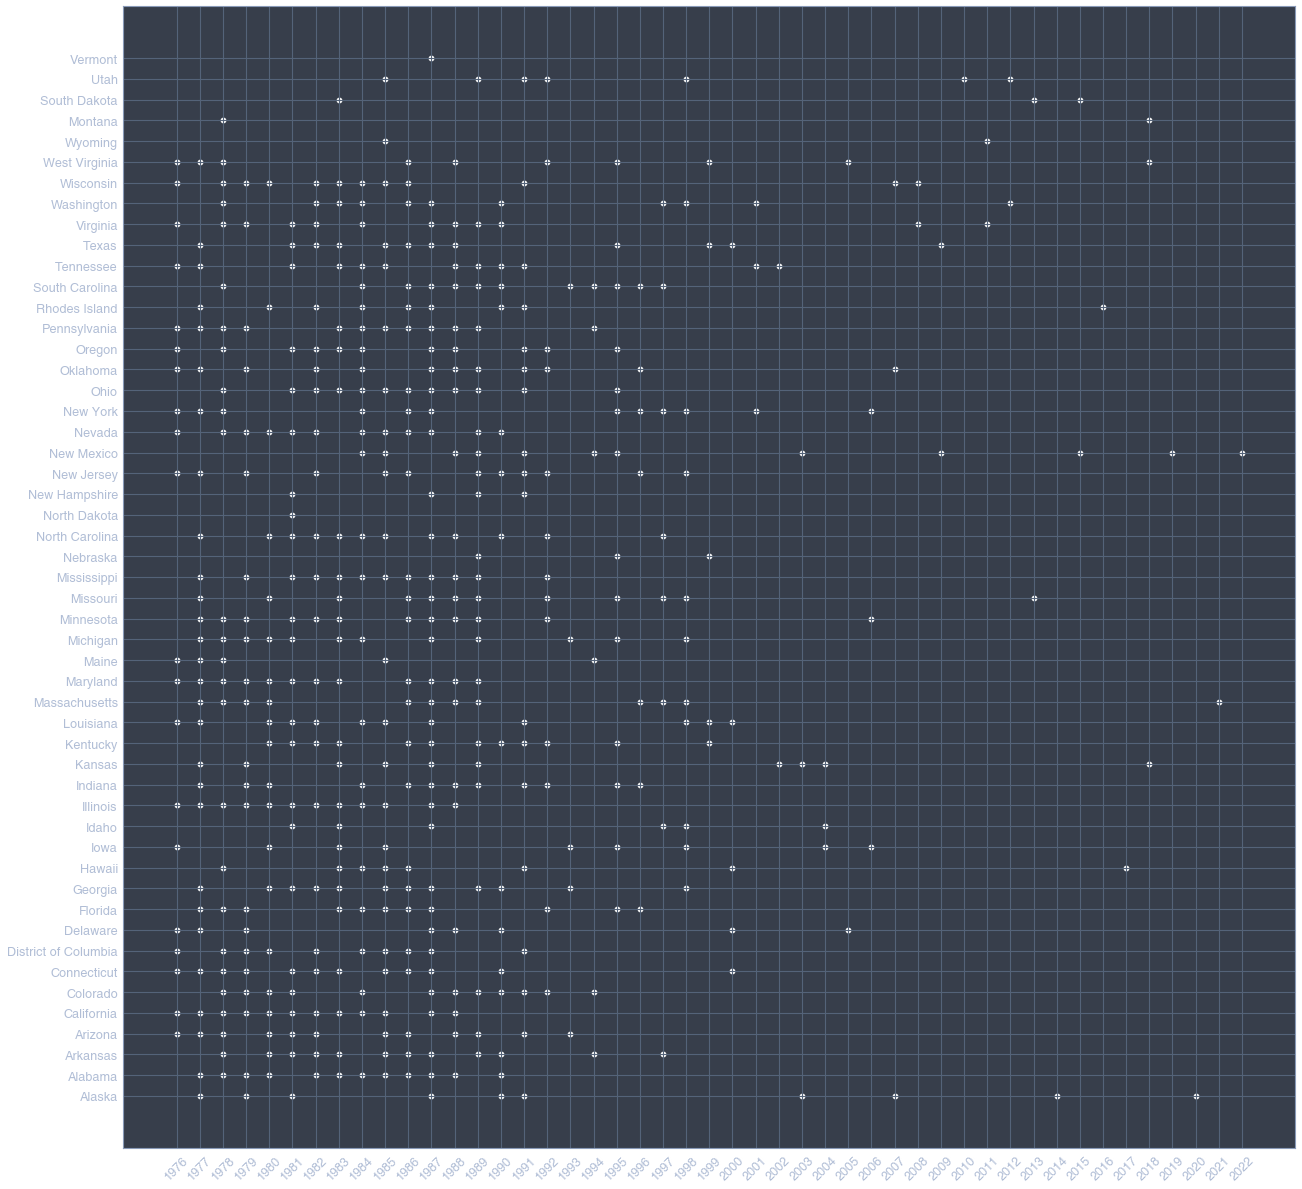

In [13]:
ratio_75_female_male_unslvd = ratio_75('VicSex', ratio=['Female', 'Male'], data_params={'Solved': 'No'})

In [ ]:
# South Carolina [1986-1990] [1993-1997]
# Pennsylvania [1983-1989]
# Ohio [1981-1989]
# Mississippi [1981-1989]
# Maryland [1976-1982]
# Illinois [1976-1985]
# California [1976-1985]
# Alabama [1982-1988]

## Unsolved > Solved

In [13]:
def unsolved_outliers():
    unslvd_out = pd.DataFrame(index=map_data['State'].unique(), columns=['Unsolved - Solved > 0'])
    
    for state in map_data['State'].unique():
        fm_unslvd = map_data[(map_data['Solved']=='No')
                             & (map_data['State']==state)].groupby(['Year', 'VicSex']).count()['Ori'].to_frame()

        fm_slvd = map_data[(map_data['Solved']=='Yes')
                           & (map_data['State']==state)].groupby(['Year', 'VicSex']).count()['Ori'].to_frame()

        fm_unslvd_pv = pd.pivot_table(fm_unslvd, index='Year', columns='VicSex', values='Ori')
        fm_slvd_pv = pd.pivot_table(fm_slvd, index='Year', columns='VicSex', values='Ori')

        fm_unslvd_pv['Female/Male Unsolved'] = fm_unslvd_pv['Female'] / fm_unslvd_pv['Male']
        fm_unslvd_pv['Female/Male Solved'] = fm_slvd_pv['Female'] / fm_slvd_pv['Male']
        fm_unslvd_pv['Unsolved - Solved'] = fm_unslvd_pv['Female/Male Unsolved'] - fm_unslvd_pv['Female/Male Solved']
        
        unslvd_out.loc[state, 'Unsolved - Solved > 0'] = fm_unslvd_pv[fm_unslvd_pv['Unsolved - Solved']>0].index.to_list()
        
    unslvd_out['coords'] = unslvd_out['Unsolved - Solved > 0'].apply(lambda row: [year%1976 for year in row])
        
    return unslvd_out
        

In [16]:
def visualize_unsolved_outliers(unslvd_out):
    fig, ax = plt.subplots(1, figsize=(21, 21))

    x_labels = np.arange(1976, 2023)
    y_labels = list(unslvd_out.index)

    for i in range(1, unslvd_out.shape[0]+1): 
        ax.scatter(unslvd_out.iloc[i-1]['coords'],
                   np.ones(len(unslvd_out.iloc[i-1]['Unsolved - Solved > 0']))*i, color='w')

    ax.set_yticks(np.arange(1, len(y_labels)+1))
    ax.set_xticks(np.arange(0, 47))

    ax.set_xticklabels(x_labels, rotation=45)
    ax.set_yticklabels(y_labels);
    

In [14]:
unslvd_out = unsolved_outliers()

unslvd_out.head()

,Unsolved - Solved > 0,coords
Alaska,"[1977, 1979, 1980, 1981, 1982, 1984, 1987, 199...","[1, 3, 4, 5, 6, 8, 11, 14, 15, 16, 17, 19, 21,..."
Alabama,"[1977, 1978, 1979, 1980, 1982, 1983, 1984, 198...","[1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1..."
Arkansas,"[1978, 1979, 1980, 1981, 1982, 1983, 1985, 198...","[2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, ..."
Arizona,"[1976, 1978, 1980, 1981, 1982, 1985, 1986, 198...","[0, 2, 4, 5, 6, 9, 10, 12, 15, 17, 19, 20, 22,..."
California,"[1976, 1977, 1979, 1980, 1983]","[0, 1, 3, 4, 7]"


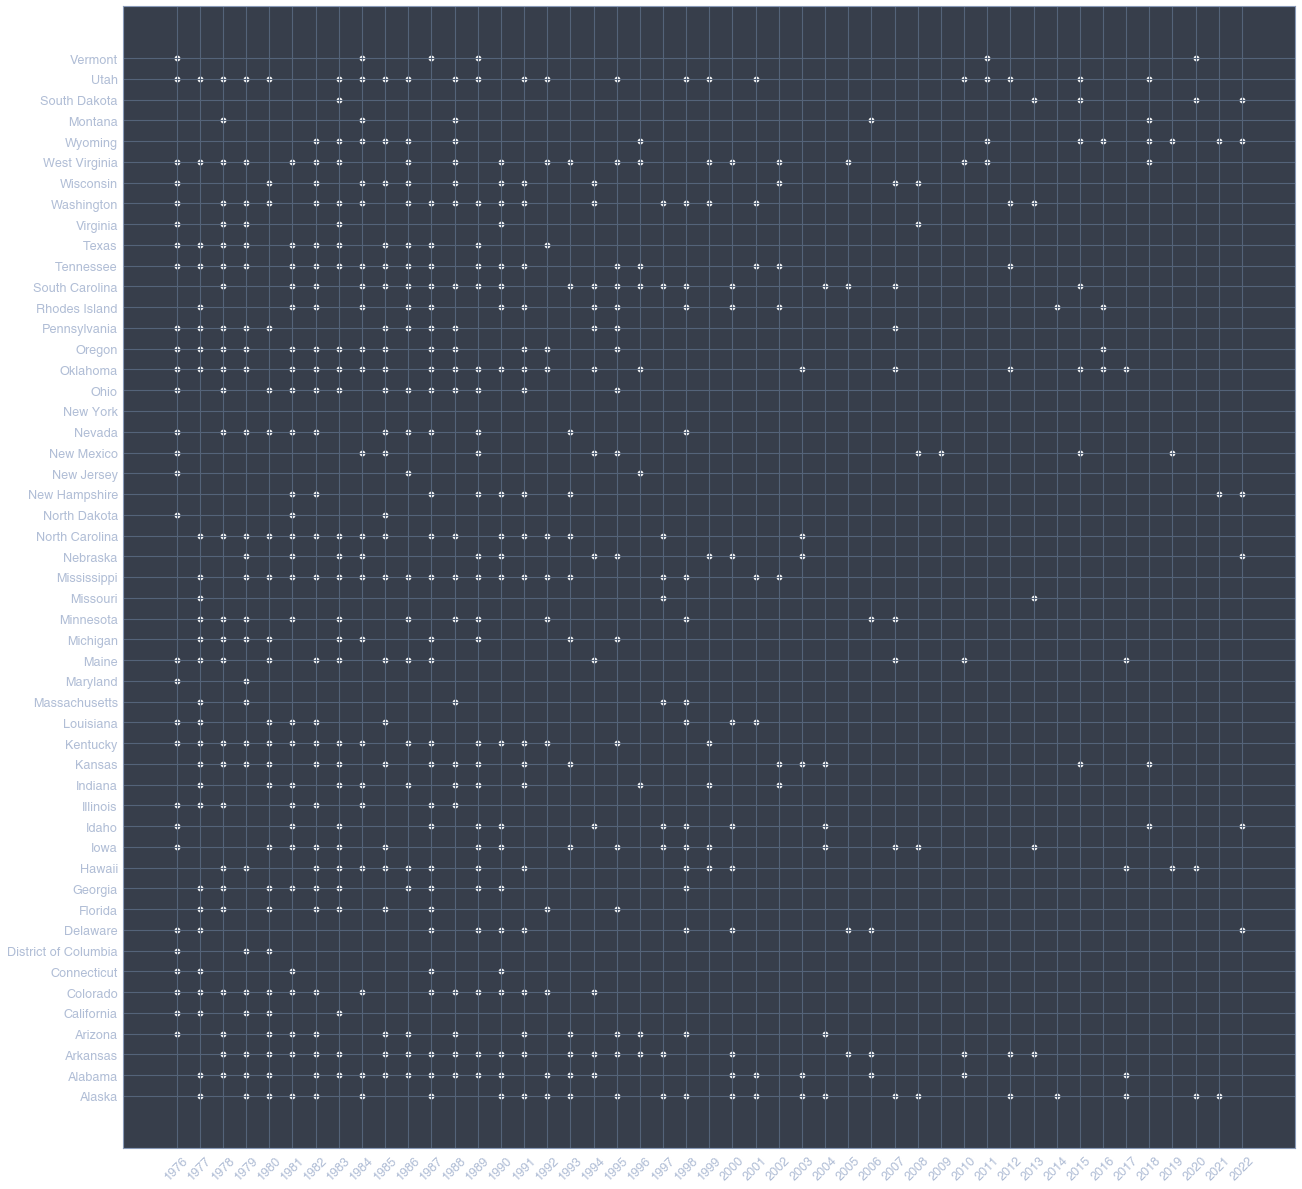

In [17]:
visualize_unsolved_outliers(unslvd_out)

In [10]:
wyo = map_data[map_data['State']=='Wyoming']
wyo[wyo['Solved']=='No'].groupby(['Year', 'VicSex']).count()

CNTYFIPS  Ori  State  Agency  Agentype  Source  Solved  Month  \
Year VicSex                                                                  
1976 Male           3    3      3       3         3       3       3      3   
1977 Male           1    1      1       1         1       1       1      1   
1978 Male           1    1      1       1         1       1       1      1   
1979 Female         1    1      1       1         1       1       1      1   
     Male           7    7      7       7         7       7       7      7   
1980 Female         1    1      1       1         1       1       1      1   
     Male           4    4      4       4         4       4       4      4   
1981 Male           2    2      2       2         2       2       2      2   
1982 Female         3    3      3       3         3       3       3      3   
     Male           4    4      4       4         4       4       4      4   
1983 Female         2    2      2       2         2       2       2      2   
     Male           3    3      3       3         3       3       3      3   
1984 Female         2    2      2       2         2       2       2      2   
     Male           2    2      2       2         2       2       2      2   
1985 Female         5    5      5       5         5       5       5      5   
     Male           2    2      2       2         2       2       2      2   
1986 Female         1    1      1       1         1       1       1      1   
     Male           1    1      1       1         1       1       1      1   
1987 Male           2    2      2       2         2       2       2      2   
1988 Female         1    1      1       1         1       1       1      1   
     Male           1    1      1       1         1       1       1      1   
1989 Male           2    2      2       2         2       2       2      2   
1990 Male           1    1      1       1         1       1       1      1   
1992 Female         1    1      1       1         1       1       1      1   
1993 Male           1    1      1       1         1       1       1      1   
1994 Male           1    1      1       1         1       1       1      1   
1995 Female         1    1      1       1         1       1       1      1   
1996 Female         1    1      1       1         1       1       1      1   
     Male           1    1      1       1         1       1       1      1   
1999 Male           1    1      1       1         1       1       1      1   
2000 Male           1    1      1       1         1       1       1      1   
2001 Male           2    2      2       2         2       2       2      2   
2002 Male           2    2      2       2         2       2       2      2   
2004 Male           2    2      2       2         2       2       2      2   
2006 Male           2    2      2       2         2       2       2      2   
2007 Male           1    1      1       1         1       1       1      1   
2011 Female         2    2      2       2         2       2       2      2   
     Male           1    1      1       1         1       1       1      1   
2012 Female         1    1      1       1         1       1       1      1   
2014 Male           1    1      1       1         1       1       1      1   
2015 Female         1    1      1       1         1       1       1      1   
     Male           2    2      2       2         2       2       2      2   
2016 Female         1    1      1       1         1       1       1      1   
     Male           1    1      1       1         1       1       1      1   
2018 Female         1    1      1       1         1       1       1      1   
     Male           2    2      2       2         2       2       2      2   
2019 Female         1    1      1       1         1       1       1      1   
     Male           1    1      1       1         1       1       1      1   
2021 Female         5    5      5       5         5       5       5      5   
     Male           5    5      5  

In [13]:
wyo[(wyo['Year']==1985)
    & (wyo['VicSex']=='Female')
    & (wyo['Solved']=='No')
   ].groupby(['VicAge', 'VicRace']).count()

,,CNTYFIPS,Ori,State,Agency,Agentype,Source,Solved,Year,Month,Incident,...,OffRace,OffEthnic,Weapon,Relationship,Circumstance,Subcircum,VicCount,OffCount,FileDate,MSA
VicAge,VicRace,,,,,,,,,,,,,,,,,,,,,
13,White,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,1,1,1,1
16,White,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,1,1,1,1
23,White,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,1,1,1,1
30,White,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,0,2,2,2,2


In [14]:
wyo[(wyo['Year']==1985)
    & (wyo['VicSex']=='Female')
    & (wyo['Solved']=='No')
    & (wyo['VicAge']<17)
   ]

,CNTYFIPS,Ori,State,Agency,Agentype,Source,Solved,Year,Month,Incident,...,OffRace,OffEthnic,Weapon,Relationship,Circumstance,Subcircum,VicCount,OffCount,FileDate,MSA
ID,,,,,,,,,,,,,,,,,,,,,
198502001WY01902,"Sweetwater, WY",WY01902,Wyoming,Rock Springs,Municipal police,FBI,No,1985,February,1,...,Unknown,Unknown or not reported,Other or type unknown,Relationship not determined,Circumstances undetermined,NaN,0,0,70385.0,Rural Wyoming
198509001WY00700,"Fremont, WY",WY00700,Wyoming,Fremont County,Sheriff,FBI,No,1985,September,1,...,Unknown,Unknown or not reported,"Personal weapons, includes beating",Relationship not determined,All suspected felony type,NaN,0,0,120685.0,Rural Wyoming


In [10]:
r = wyo[(wyo['Year']==2021) & (wyo['Solved']=='No') & (wyo['VicSex']=='Female')]
r

,CNTYFIPS,Ori,State,Agency,Agentype,Source,Solved,Year,Month,Incident,...,OffRace,OffEthnic,Weapon,Relationship,Circumstance,Subcircum,VicCount,OffCount,FileDate,MSA
ID,,,,,,,,,,,,,,,,,,,,,
202104009WY01104,"Laramie, WY",WY01104,Wyoming,Wyoming Division of Crime,Primary state LE,FBI,No,2021,April,9,...,Unknown,Unknown or not reported,"Narcotics or drugs, sleeping pills",Relationship not determined,All other manslaughter by negligence,NaN,0,0,NaN,"Cheyenne, WY"
202106002WY01104,"Laramie, WY",WY01104,Wyoming,Wyoming Division of Crime,Primary state LE,FBI,No,2021,June,2,...,Unknown,Unknown or not reported,"Narcotics or drugs, sleeping pills",Relationship not determined,All other manslaughter by negligence,NaN,0,0,NaN,"Cheyenne, WY"
202109001WY01104,"Laramie, WY",WY01104,Wyoming,Wyoming Division of Crime,Primary state LE,FBI,No,2021,September,1,...,Unknown,Unknown or not reported,"Narcotics or drugs, sleeping pills",Relationship not determined,All other manslaughter by negligence,NaN,0,0,NaN,"Cheyenne, WY"
202109001WY02000,"Teton, WY",WY02000,Wyoming,Teton County,Sheriff,FBI,No,2021,September,1,...,Unknown,Unknown or not reported,Other or type unknown,Relationship not determined,Circumstances undetermined,NaN,0,0,NaN,Rural Wyoming
202110004WY01104,"Laramie, WY",WY01104,Wyoming,Wyoming Division of Crime,Primary state LE,FBI,No,2021,October,4,...,Unknown,Unknown or not reported,"Narcotics or drugs, sleeping pills",Relationship not determined,All other manslaughter by negligence,NaN,0,0,NaN,"Cheyenne, WY"


In [6]:
wyo[(wyo['Year']==2021) & (wyo['Solved']=='No') & (wyo['VicSex']=='Male')]

,CNTYFIPS,Ori,State,Agency,Agentype,Source,Solved,Year,Month,Incident,...,OffRace,OffEthnic,Weapon,Relationship,Circumstance,Subcircum,VicCount,OffCount,FileDate,MSA
ID,,,,,,,,,,,,,,,,,,,,,
202103001WY01104,"Laramie, WY",WY01104,Wyoming,Wyoming Division of Crime,Primary state LE,FBI,No,2021,March,1,...,Unknown,Unknown or not reported,"Narcotics or drugs, sleeping pills",Relationship not determined,All other manslaughter by negligence,NaN,0,0,NaN,"Cheyenne, WY"
202104008WY01104,"Laramie, WY",WY01104,Wyoming,Wyoming Division of Crime,Primary state LE,FBI,No,2021,April,8,...,Unknown,Unknown or not reported,"Personal weapons, includes beating",Relationship not determined,Institutional killings,NaN,0,0,NaN,"Cheyenne, WY"
202107001WY01101,"Laramie, WY",WY01101,Wyoming,Cheyenne,Municipal police,FBI,No,2021,July,1,...,Unknown,Unknown or not reported,"Firearm, type not stated",Relationship not determined,Juvenile gang killings,NaN,0,0,50321.0,"Cheyenne, WY"
202108007WY01104,"Laramie, WY",WY01104,Wyoming,Wyoming Division of Crime,Primary state LE,FBI,No,2021,August,7,...,Unknown,Unknown or not reported,"Narcotics or drugs, sleeping pills",Relationship not determined,All other manslaughter by negligence,NaN,0,0,NaN,"Cheyenne, WY"
202108008WY01104,"Laramie, WY",WY01104,Wyoming,Wyoming Division of Crime,Primary state LE,FBI,No,2021,August,8,...,Unknown,Unknown or not reported,"Narcotics or drugs, sleeping pills",Relationship not determined,All other manslaughter by negligence,NaN,0,0,NaN,"Cheyenne, WY"


In [11]:
wyo[(wyo['MSA']=='Cheyenne, WY')
    & (wyo['VicSex']=='Female')
    & (wyo['Year'].isin(np.arange(1999, 2024)))].groupby('Weapon').count()

,CNTYFIPS,Ori,State,Agency,Agentype,Source,Solved,Year,Month,Incident,...,OffSex,OffRace,OffEthnic,Relationship,Circumstance,Subcircum,VicCount,OffCount,FileDate,MSA
Weapon,,,,,,,,,,,,,,,,,,,,,
Fire,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,1,1,1,1
"Firearm, type not stated",2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,0,2,2,2,2
"Handgun - pistol, revolver, etc",2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,0,2,2,2,2
Knife or cutting instrument,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,0,3,3,3,3
"Narcotics or drugs, sleeping pills",8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,0,8,8,1,8
Other or type unknown,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,0,3,3,2,3
"Personal weapons, includes beating",3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,0,3,3,2,3
Rifle,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,1,1,1,1
Shotgun,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,0,4,4,4,4


In [9]:
wyo[(wyo['MSA']=='Cheyenne, WY')
    & (wyo['Solved']=='No')
    & (wyo['VicSex']=='Female')
    & (wyo['Year'].isin(np.arange(1999, 2024)))].groupby('Weapon').count()

,CNTYFIPS,Ori,State,Agency,Agentype,Source,Solved,Year,Month,Incident,...,OffSex,OffRace,OffEthnic,Relationship,Circumstance,Subcircum,VicCount,OffCount,FileDate,MSA
Weapon,,,,,,,,,,,,,,,,,,,,,
"Narcotics or drugs, sleeping pills",5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,0,5,5,0,5


In [10]:
wyo[(wyo['MSA']=='Cheyenne, WY')
    & (wyo['Solved']=='No')
    & (wyo['VicSex']=='Male')
    & (wyo['Year'].isin(np.arange(1999, 2024)))].groupby('Weapon').count()

,CNTYFIPS,Ori,State,Agency,Agentype,Source,Solved,Year,Month,Incident,...,OffSex,OffRace,OffEthnic,Relationship,Circumstance,Subcircum,VicCount,OffCount,FileDate,MSA
Weapon,,,,,,,,,,,,,,,,,,,,,
"Firearm, type not stated",1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,1,1,1,1
"Handgun - pistol, revolver, etc",5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,0,5,5,5,5
"Narcotics or drugs, sleeping pills",4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,0,4,4,0,4
"Personal weapons, includes beating",1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,1,1,0,1
Shotgun,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,1,1,0,1


In [12]:
wyo[(wyo['MSA']=='Cheyenne, WY')
    & (wyo['Year'].isin(np.arange(1975, 1999)))].groupby('Weapon').count()

,CNTYFIPS,Ori,State,Agency,Agentype,Source,Solved,Year,Month,Incident,...,OffSex,OffRace,OffEthnic,Relationship,Circumstance,Subcircum,VicCount,OffCount,FileDate,MSA
Weapon,,,,,,,,,,,,,,,,,,,,,
"Blunt object - hammer, club, etc",3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,0,3,3,3,3
"Handgun - pistol, revolver, etc",24,24,24,24,24,24,24,24,24,24,...,24,24,24,24,24,1,24,24,24,24
Knife or cutting instrument,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,0,10,10,10,10
Other or type unknown,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,0,5,5,5,5
"Personal weapons, includes beating",14,14,14,14,14,14,14,14,14,14,...,14,14,14,14,14,0,14,14,14,14
Rifle,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,0,5,5,5,5
Shotgun,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,0,5,5,5,5
Strangulation - hanging,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,0,3,3,3,3


In [19]:
wyo[(wyo['Weapon']=='Narcotics or drugs, sleeping pills')
    & (wyo['Solved']=='No')
#     & (wyo['VicSex']=='Female')
    & (True)].groupby(['Year', 'MSA', 'VicSex']).count()

CNTYFIPS  Ori  State  Agency  Agentype  Source  \
Year MSA           VicSex                                                   
2012 Rural Wyoming Female         1    1      1       1         1       1   
2021 Cheyenne, WY  Female         4    4      4       4         4       4   
                   Male           3    3      3       3         3       3   
2022 Cheyenne, WY  Female         1    1      1       1         1       1   
                   Male           1    1      1       1         1       1   

                           Solved  Month  Incident  ActionType  ...  OffSex  \
Year MSA           VicSex                                       ...           
2012 Rural Wyoming Female       1      1         1           1  ...       1   
2021 Cheyenne, WY  Female       4      4         4           4  ...       4   
                   Male         3      3         3           3  ...       3   
2022 Cheyenne, WY  Female       1      1         1           1  ...       1   
                   Male         1      1         1           1  ...       1   

                           OffRace  OffEthnic  Weapon  Relationship  \
Year MSA           VicSex                                             
2012 Rural Wyoming Female        1          1       1             1   
2021 Cheyenne, WY  Female        4          4       4             4   
                   Male          3          3       3             3   
2022 Cheyenne, WY  Female        1          1       1             1   
                   Male          1          1       1             1   

                           Circumstance  Subcircum  VicCount  OffCount  \
Year MSA           VicSex                                                
2012 Rural Wyoming Female             1          0         1         1   
2021 Cheyenne, WY  Female             4          0         4         4   
                   Male               3          0         3         3   
2022 Cheyenne, WY  Female             1          0         1         1   
                   Male               1          0         1         1   

                           FileDate  
Year MSA           VicSex            
2012 Rural Wyoming Female         1  
2021 Cheyenne, WY  Female         0  
                   Male           0  
2022 Cheyenne, WY  Female         0  
                   Male           0  

[5 rows x 26 columns]

In [4]:
narco = map_data[(map_data['Weapon']=='Narcotics or drugs, sleeping pills')
#          & (map_data['Solved']=='No')
         & (map_data['VicSex']=='Female')
         & (True)].groupby(['State', 'Solved']).count()['Ori'].to_frame()

narco_pv = pd.pivot_table(narco, index='State', columns='Solved', values='Ori')

narco_pv.fillna(0, inplace=True)
narco_pv['No/Yes'] = narco_pv['No'] / narco_pv['Yes']
narco_pv

Solved,No,Yes,No/Yes
State,,,
Alabama,0.0,7.0,0.000000
Alaska,1.0,5.0,0.200000
Arizona,6.0,26.0,0.230769
Arkansas,0.0,7.0,0.000000
California,16.0,108.0,0.148148
Colorado,2.0,28.0,0.071429
Connecticut,2.0,15.0,0.133333
Delaware,1.0,1.0,1.000000
District of Columbia,0.0,6.0,0.000000


In [9]:
narco_pv[(narco_pv['No/Yes'] > narco_pv['No/Yes'].quantile(q=.75)) & (narco_pv['No']>5)]

Solved,No,Yes,No/Yes
State,,,
Arizona,6.0,26.0,0.230769
Kentucky,11.0,34.0,0.323529
Pennsylvania,15.0,58.0,0.258621
Wyoming,6.0,7.0,0.857143


## Weapons and Circumstance Pattern

In [30]:
weapon_circum = map_data[map_data['Solved']=='Yes'].groupby(['Weapon', 'Circumstance']).count()['CNTYFIPS'].to_frame()
weapon_circum = pd.pivot_table(weapon_circum, index='Weapon', columns='Circumstance', values='CNTYFIPS')
weapon_circum.fillna(0, inplace=True)

weapon_circum.head()

Circumstance,Abortion,All other manslaughter by negligence,All suspected felony type,Argument over money or property,Arson,Brawl due to influence of alcohol,Brawl due to influence of narcotics,Burglary,Child killed by babysitter,Children playing with gun,...,Other,Other - not specified,Other arguments,Other negligent handling of gun,Other sex offense,Prostitution and commercialized vice,Rape,Robbery,Sniper attack,Victim shot in hunting accident
Weapon,,,,,,,,,,,,,,,,,,,,,
Asphyxiation - includes death by gas,1.0,304.0,39.0,34.0,74.0,22.0,28.0,54.0,41.0,0.0,...,1565.0,203.0,639.0,0.0,28.0,8.0,102.0,219.0,0.0,0.0
"Blunt object - hammer, club, etc",0.0,151.0,249.0,779.0,37.0,767.0,167.0,477.0,132.0,0.0,...,4437.0,901.0,8709.0,5.0,137.0,23.0,334.0,3073.0,1.0,1.0
Drowning,0.0,248.0,16.0,8.0,0.0,10.0,2.0,6.0,9.0,0.0,...,582.0,68.0,114.0,1.0,7.0,3.0,17.0,27.0,1.0,0.0
Explosives,0.0,24.0,7.0,3.0,28.0,1.0,1.0,1.0,0.0,0.0,...,237.0,35.0,44.0,0.0,1.0,0.0,0.0,5.0,0.0,0.0
Fire,0.0,291.0,37.0,30.0,2589.0,36.0,1.0,48.0,3.0,3.0,...,728.0,286.0,693.0,6.0,7.0,6.0,11.0,67.0,0.0,0.0


In [4]:
min_max_scaler = preprocessing.MinMaxScaler()
def make_it_min_max(df):
    min_max_ = pd.DataFrame(index=df.index, columns=df.columns)

    for i in range(len(df.index)):
        min_max_.iloc[i] = min_max_scaler.fit_transform(df.iloc[i].to_frame())[:, 0]
    
    return min_max_

In [6]:
min_max_w_c = make_it_min_max(weapon_circum)
min_max_w_c.head()

Circumstance,Abortion,All other manslaughter by negligence,All suspected felony type,Argument over money or property,Arson,Brawl due to influence of alcohol,Brawl due to influence of narcotics,Burglary,Child killed by babysitter,Children playing with gun,...,Other,Other - not specified,Other arguments,Other negligent handling of gun,Other sex offense,Prostitution and commercialized vice,Rape,Robbery,Sniper attack,Victim shot in hunting accident
Weapon,,,,,,,,,,,,,,,,,,,,,
Asphyxiation - includes death by gas,0.000639,0.194249,0.02492,0.021725,0.047284,0.014058,0.017891,0.034505,0.026198,0.0,...,1.0,0.129712,0.408307,0.0,0.017891,0.005112,0.065176,0.139936,0.0,0.0
"Blunt object - hammer, club, etc",0.0,0.017338,0.028591,0.089448,0.004248,0.08807,0.019176,0.054771,0.015157,0.0,...,0.509473,0.103456,1.0,0.000574,0.015731,0.002641,0.038351,0.352853,0.000115,0.000115
Drowning,0.0,0.426117,0.027491,0.013746,0.0,0.017182,0.003436,0.010309,0.015464,0.0,...,1.0,0.116838,0.195876,0.001718,0.012027,0.005155,0.02921,0.046392,0.001718,0.0
Explosives,0.0,0.101266,0.029536,0.012658,0.118143,0.004219,0.004219,0.004219,0.0,0.0,...,1.0,0.147679,0.185654,0.0,0.004219,0.0,0.0,0.021097,0.0,0.0
Fire,0.0,0.112399,0.014291,0.011587,1.0,0.013905,0.000386,0.01854,0.001159,0.001159,...,0.28119,0.110467,0.267671,0.002317,0.002704,0.002317,0.004249,0.025879,0.0,0.0


In [4]:
weapons_list = map_data['Weapon'].unique()
circumstance_list = map_data['Circumstance'].unique()
years_list = map_data['Year'].unique()
states = map_data['State'].unique()

data_solved = map_data[(map_data['Solved']=='Yes') & (map_data['VicSex']=='Female')]
data_unsolved = map_data[(map_data['Solved']=='No') & (map_data['VicSex']=='Female')]

w = data_solved\
    .groupby(['State',
              'Year',
              'Weapon',
              'Circumstance'])\
    .count()['CNTYFIPS']\
    .to_frame()

uw = data_unsolved\
     .groupby(['State',
              'Year',
              'Weapon',
              'Circumstance'])\
     .count()['CNTYFIPS']\
     .to_frame()

def get_cosine_similarity_circumstances(weapon):
    full_cosine = pd.DataFrame(index=years_list)
    for state in states:
        if weapon not in data_solved[data_solved['State']==state]['Weapon'].unique()\
        or weapon not in data_unsolved[data_unsolved['State']==state]['Weapon'].unique():
            continue
            
        temp = pd.DataFrame(index=years_list, columns=circumstance_list, data=0)
        pivot_w = pd.pivot_table(w.loc[state, :, weapon],
                                 index='Year',
                                 columns=['Circumstance'],
                                 values='CNTYFIPS')
        pivot_w = pivot_w + temp
        pivot_w.fillna(0, inplace=True)
        
        pivot_uw = pd.pivot_table(uw.loc[state, :, weapon],
                                  index='Year',
                                  columns=['Circumstance'],
                                  values='CNTYFIPS')
        pivot_uw = pivot_uw + temp
        pivot_uw.fillna(0, inplace=True)
        
        r = cosine_similarity(pivot_w.to_numpy(), pivot_uw.to_numpy())
        res = pd.DataFrame(index=years_list, columns=years_list, data=r)
        
        full_cosine[state] = np.diag(res)
    
    return full_cosine


# def cosine_similarity_by_circumstance(weapons):
#     weapon_pack = {}
#     if weapons == 'all':
#         for weapon in weapons_list:
#             weapon_pack[weapon] = get_cosine_similarity_circumstances(weapon)
#     else:
#         for weapon in weapons:
#             weapon_pack[weapon] = get_cosine_similarity_circumstances(weapon)
            
#     return weapon_pack


In [21]:
weapons_df = {}
for weapon in weapons_list:
    weapons_df[weapon] = get_cosine_similarity_circumstances(weapon)

In [22]:
# with open('data/weapons_female_victims_df.pickle', 'wb') as f:
#     pk.dump(weapons_df, f, pk.HIGHEST_PROTOCOL)

In [5]:
with open('data/weapons_female_victims_df.pickle', 'rb') as f:
    weapons_df = pk.load(f)

In [9]:
cs = get_cosine_similarity_circumstances('Handgun - pistol, revolver, etc')

In [20]:
weapons_solved = map_data[map_data['Solved']=='Yes'].groupby('Weapon').count().sort_values(by='Ori', ascending=False)['Ori']
weapons_unsolved = map_data[map_data['Solved']=='No'].groupby('Weapon').count().sort_values(by='Ori', ascending=False)['Ori']

In [45]:
weapons_popularity = pd.DataFrame(index=weapons_solved.index, columns=['Solved', 'Unsolved'], data=0)
weapons_popularity['Solved'] = weapons_solved
weapons_popularity['Unsolved'] = weapons_unsolved
weapons_popularity

,Solved,Unsolved
Weapon,,
"Handgun - pistol, revolver, etc",289898,130956
Knife or cutting instrument,97635,25447
"Firearm, type not stated",46569,40264
"Personal weapons, includes beating",40411,8126
Shotgun,33911,5801
Other or type unknown,29277,18876
Rifle,27021,4805
"Blunt object - hammer, club, etc",25797,11082
Strangulation - hanging,5560,4587


In [17]:
cs.loc[1976]['Alabama']

0.32778621184407364

In [35]:
cs[cs['California']<0.35].index

Int64Index([1977], dtype='int64')

In [40]:
cs.loc[cs[cs['Alaska']<0.35].index]['Alaska']

1977    0.291043
1978    0.247016
1979    0.230269
1980    0.000000
1981    0.199007
1982    0.097129
1983    0.081111
1984    0.203069
1987    0.196116
1988    0.134840
1989    0.188982
1990    0.000000
1991    0.301511
1995    0.304997
1996    0.299078
1997    0.164399
1998    0.000000
1999    0.288675
2001    0.301511
2003    0.000000
2004    0.188982
2007    0.000000
2008    0.000000
2009    0.000000
2010    0.000000
2011    0.000000
2012    0.000000
2013    0.000000
2014    0.000000
2015    0.000000
2016    0.000000
2017    0.000000
2018    0.000000
2019    0.316228
2020    0.000000
2021    0.000000
2022    0.000000
Name: Alaska, dtype: float64

In [44]:
cs[cs<0.35]

,Alaska,Alabama,Arkansas,Arizona,California,Colorado,Connecticut,District of Columbia,Delaware,Florida,...,Texas,Virginia,Washington,Wisconsin,West Virginia,Wyoming,Montana,South Dakota,Utah,Vermont
1976,NaN,0.327786,0.264491,0.144652,NaN,NaN,0.179896,NaN,0.000000,0.342831,...,NaN,NaN,NaN,0.169810,0.000000,0.000000,0.000000,0.0,0.105409,0.0
1977,0.291043,0.179049,0.065458,0.088098,0.287503,0.267067,0.220416,NaN,0.000000,0.195974,...,NaN,0.117972,0.149174,0.237851,0.000000,0.000000,NaN,0.0,NaN,0.0
1978,0.247016,0.184668,0.057632,NaN,NaN,0.148083,NaN,NaN,0.000000,0.206162,...,NaN,0.157685,0.197386,0.000000,0.000000,0.000000,0.000000,0.0,NaN,0.0
1979,0.230269,0.116434,0.142460,NaN,NaN,0.344896,NaN,NaN,0.000000,0.279166,...,NaN,0.191484,NaN,0.229416,0.051299,NaN,0.000000,0.0,NaN,0.0
1980,0.000000,0.094372,0.246239,NaN,NaN,0.221648,0.154196,NaN,0.000000,NaN,...,NaN,0.126488,NaN,NaN,0.076713,0.162221,0.000000,0.0,0.000000,0.0
1981,0.199007,0.087570,0.073513,NaN,NaN,NaN,0.248654,0.330398,0.000000,0.321786,...,NaN,0.169712,0.345115,NaN,0.011213,0.000000,0.000000,0.0,NaN,0.0
1982,0.097129,0.180444,NaN,0.220547,NaN,0.224468,0.178078,NaN,0.125000,0.198212,...,NaN,0.292348,0.195760,NaN,NaN,0.138675,0.000000,NaN,0.323498,0.0
1983,0.081111,0.117398,0.298829,0.168044,NaN,0.271862,NaN,NaN,0.000000,0.300363,...,NaN,0.164265,NaN,NaN,NaN,0.000000,0.000000,NaN,0.118678,0.0
1984,0.203069,0.269086,0.183664,0.300399,NaN,0.095507,0.094573,NaN,0.000000,NaN,...,NaN,0.199162,NaN,NaN,0.212298,0.000000,0.158114,0.0,0.226134,0.0
1985,NaN,0.305182,0.217479,NaN,NaN,0.290563,0.109797,NaN,0.000000,NaN,...,NaN,0.097132,NaN,NaN,0.000000,0.000000,0.000000,0.0,NaN,0.0


<AxesSubplot:>

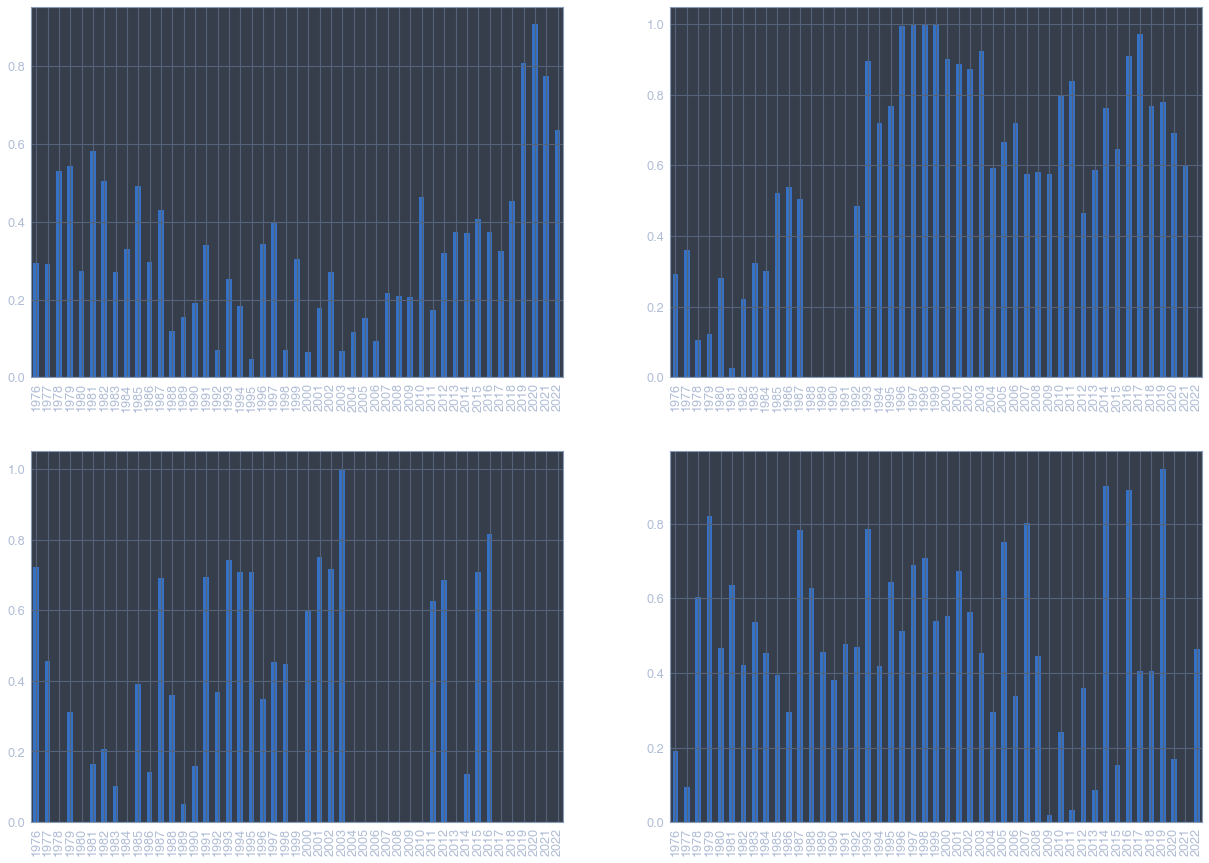

In [25]:
fig, ax = plt.subplots(2, 2, figsize=(21, 15))

weapons_df['Knife or cutting instrument']['California'].plot(kind='bar', ax=ax[0, 0])
weapons_df['Knife or cutting instrument']['Florida'].plot(kind='bar', ax=ax[0, 1])
weapons_df['Knife or cutting instrument']['Alabama'].plot(kind='bar', ax=ax[1, 0])
weapons_df['Knife or cutting instrument']['New York'].plot(kind='bar', ax=ax[1, 1])

In [7]:
weapons_df.keys()

dict_keys(['Knife or cutting instrument', 'Shotgun', 'Strangulation - hanging', 'Rifle', 'Handgun - pistol, revolver, etc', 'Personal weapons, includes beating', 'Fire', 'Other or type unknown', 'Firearm, type not stated', 'Asphyxiation - includes death by gas', 'Narcotics or drugs, sleeping pills', 'Blunt object - hammer, club, etc', 'Drowning', 'Pushed or thrown out window', 'Other gun', 'Poison - does not include gas', 'Explosives', 'Weapon Not Reported'])

In [6]:
wpn = 'Rifle'
threshold = 0.35

In [7]:
wpn_1 = weapons_df[wpn][weapons_df[wpn]<threshold]

In [25]:
x = np.repeat(np.arange(1, wpn_1.columns.shape[0]+1), 47)#.reshape(51, 47)
y = (wpn_1.isnull().to_numpy().astype(int).T * np.tile(np.arange(1, wpn_1.index.shape[0]+1), (wpn_1.columns.shape[0], 1))).flatten()

x = x[y!=0]
y = y[y!=0]

In [20]:
wpn_1.notnull()

,Alaska,Alabama,Arkansas,Arizona,California,Colorado,Connecticut,Florida,Georgia,Hawaii,...,Pennsylvania,South Carolina,Tennessee,Texas,Virginia,Washington,Wisconsin,West Virginia,Montana,Vermont
1976,True,True,True,True,False,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
1977,True,True,True,False,True,True,True,True,True,True,...,True,True,True,False,True,True,True,True,True,True
1978,True,True,True,True,True,True,True,True,True,True,...,True,True,True,False,True,True,True,True,True,True
1979,True,True,True,False,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
1980,True,True,True,True,True,True,True,True,True,True,...,True,True,True,False,True,True,True,True,True,True
1981,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
1982,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
1983,True,True,True,True,False,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
1984,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
1985,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


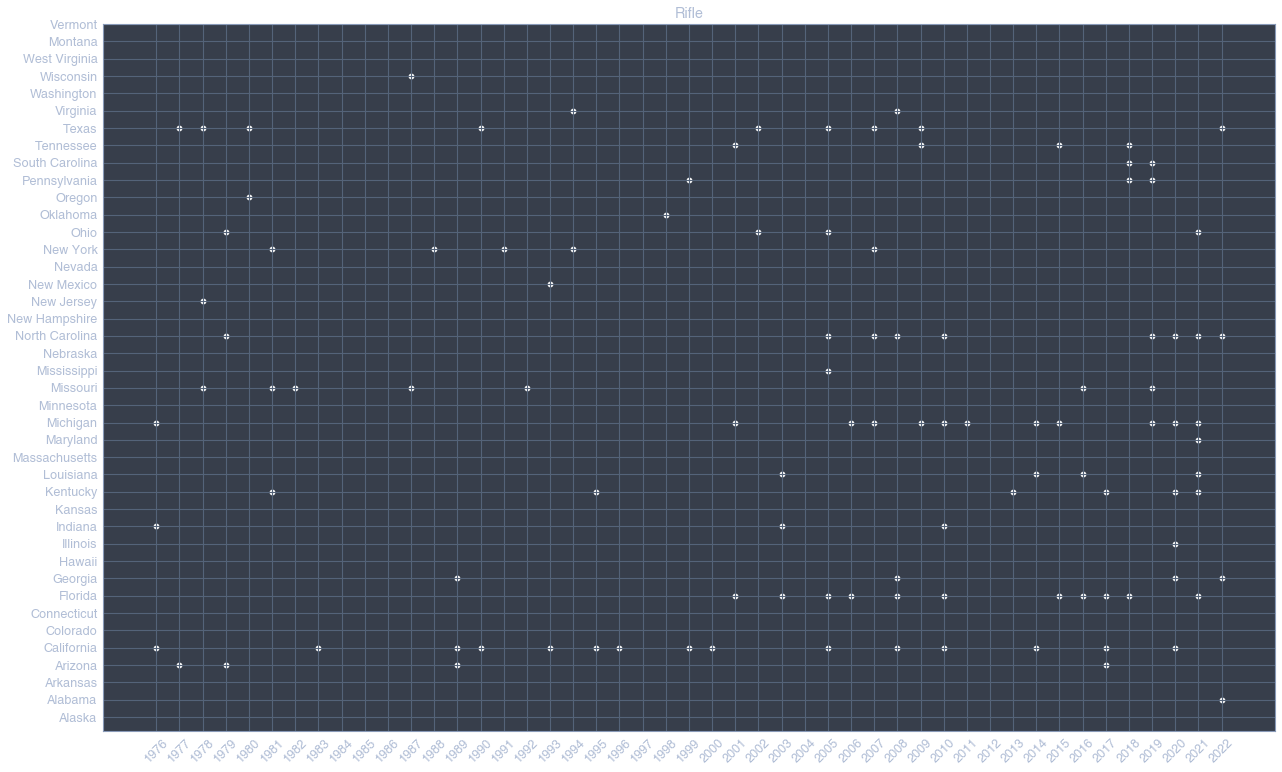

In [26]:
x_labels = np.arange(1976, 2023)
y_labels = list(wpn_1.columns)

fig, ax = plt.subplots(1, figsize=(21, 13))
ax.scatter(y, x, color='w')
ax.set_yticks(np.arange(1, len(y_labels)+1))
ax.set_xticks(np.arange(1, 48))
ax.set_xticklabels(x_labels, rotation=45)
ax.set_yticklabels(y_labels)
ax.set_title(wpn);

In [27]:
# threshold = 0.35
# x_labels = np.arange(1976, 2023)
    
# for weapon in weapons_df.keys():
#     weapon_df = weapons_df[weapon][weapons_df[weapon]<threshold]
    
#     x = weapon_df.isnull().to_numpy().astype(int).T
#     x = (x * np.tile(np.arange(1, weapon_df.index.shape[0]+1),
#                      (weapon_df.columns.shape[0], 1))).flatten()
#     y = np.repeat(np.arange(1, weapon_df.columns.shape[0]+1), 47)

#     y = y[y!=0]
#     x = x[y!=0]
    
#     y_labels = list(weapon_df.columns)

# #     print(f'{len(y_labels)}')

#     plt.figure(figsize=(21,13))
#     plt.scatter(x, y, color='w')
#     plt.yticks(np.arange(1, len(y_labels)+1), y_labels)
#     plt.xticks(np.arange(1, 48), x_labels, rotation=45)
#     plt.title(weapon);
    

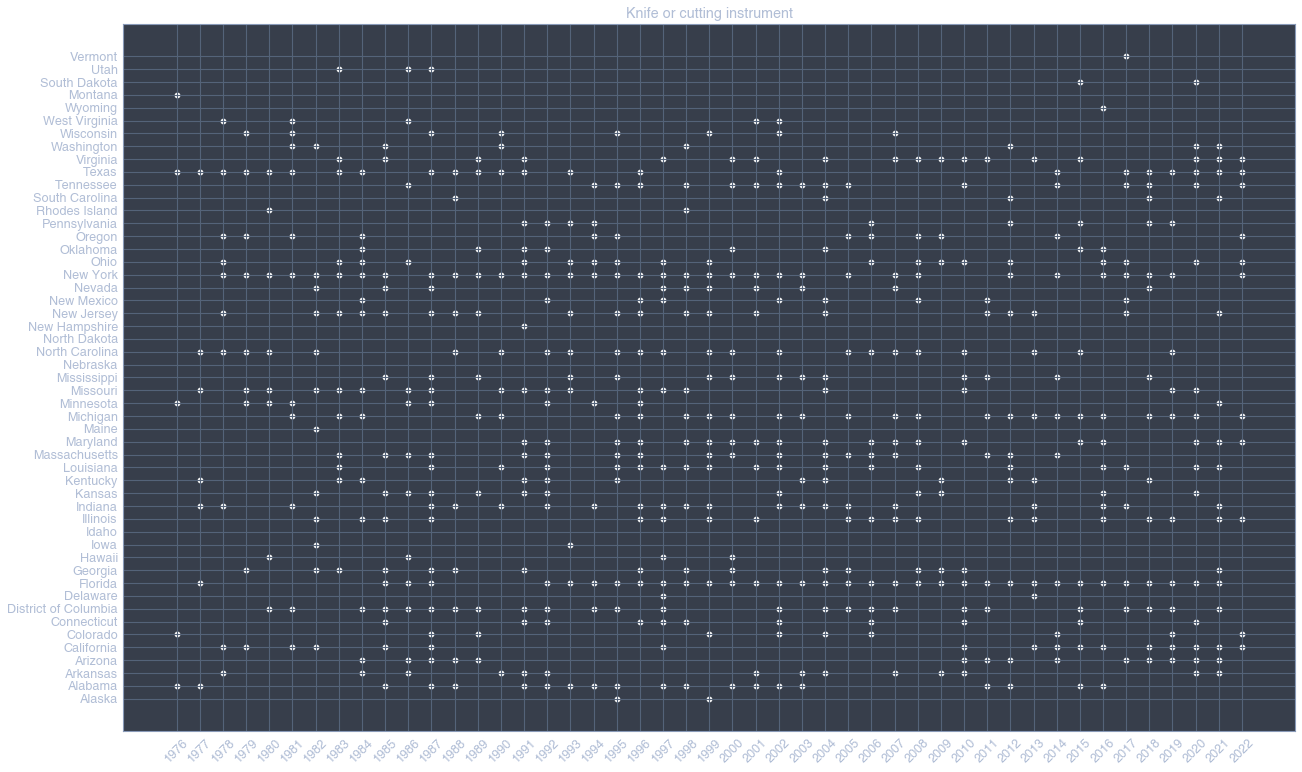

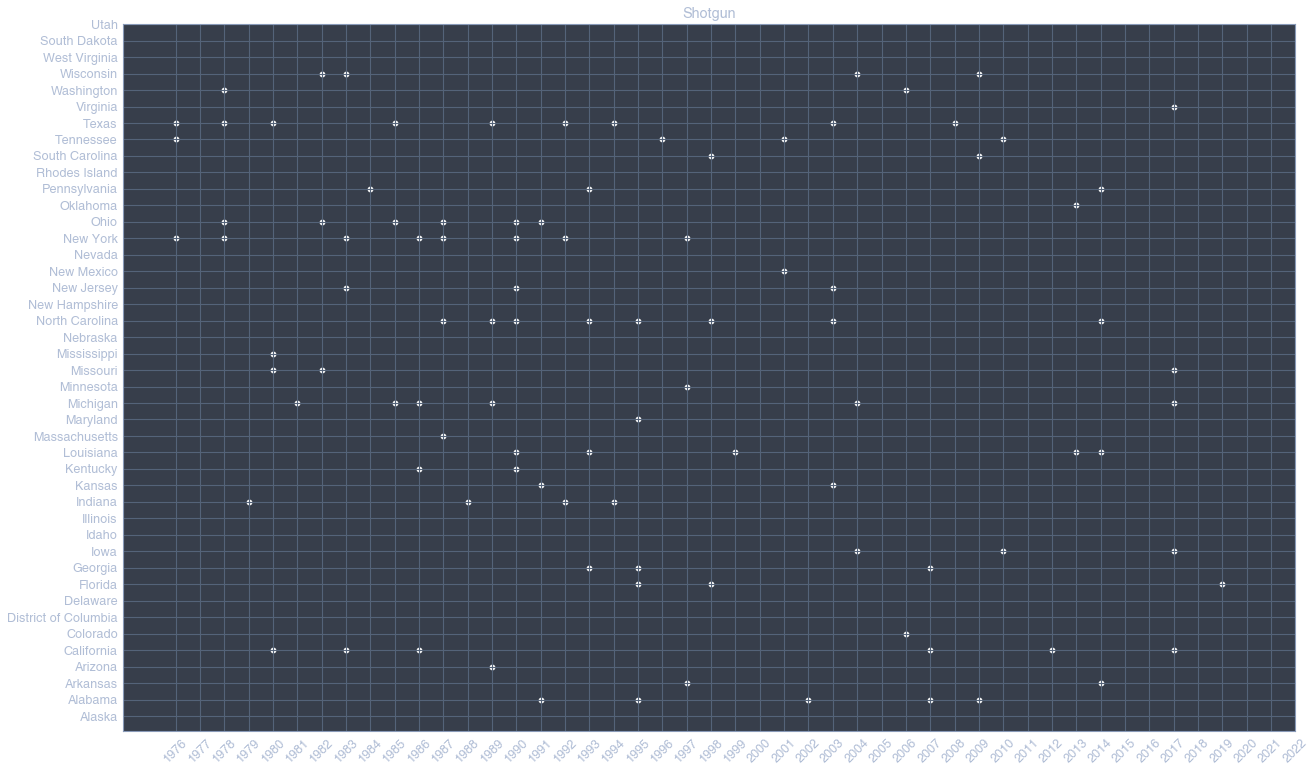

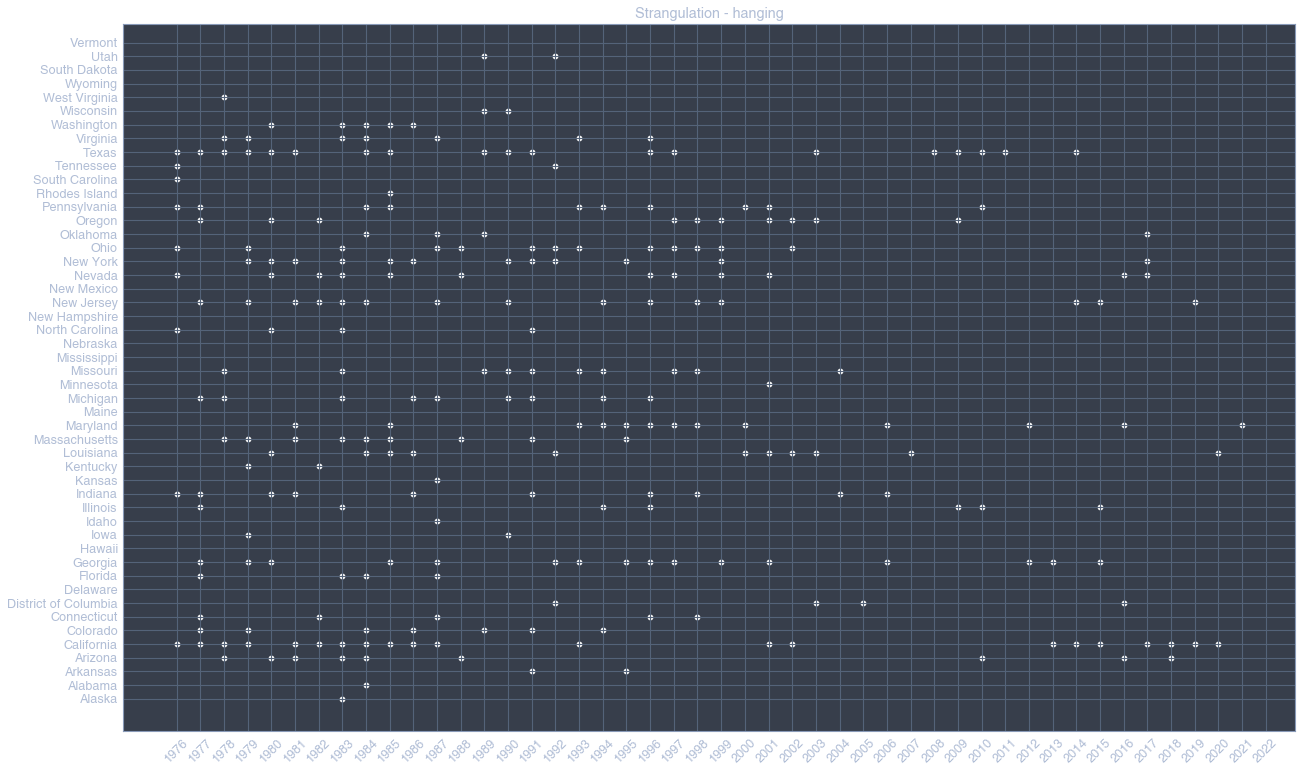

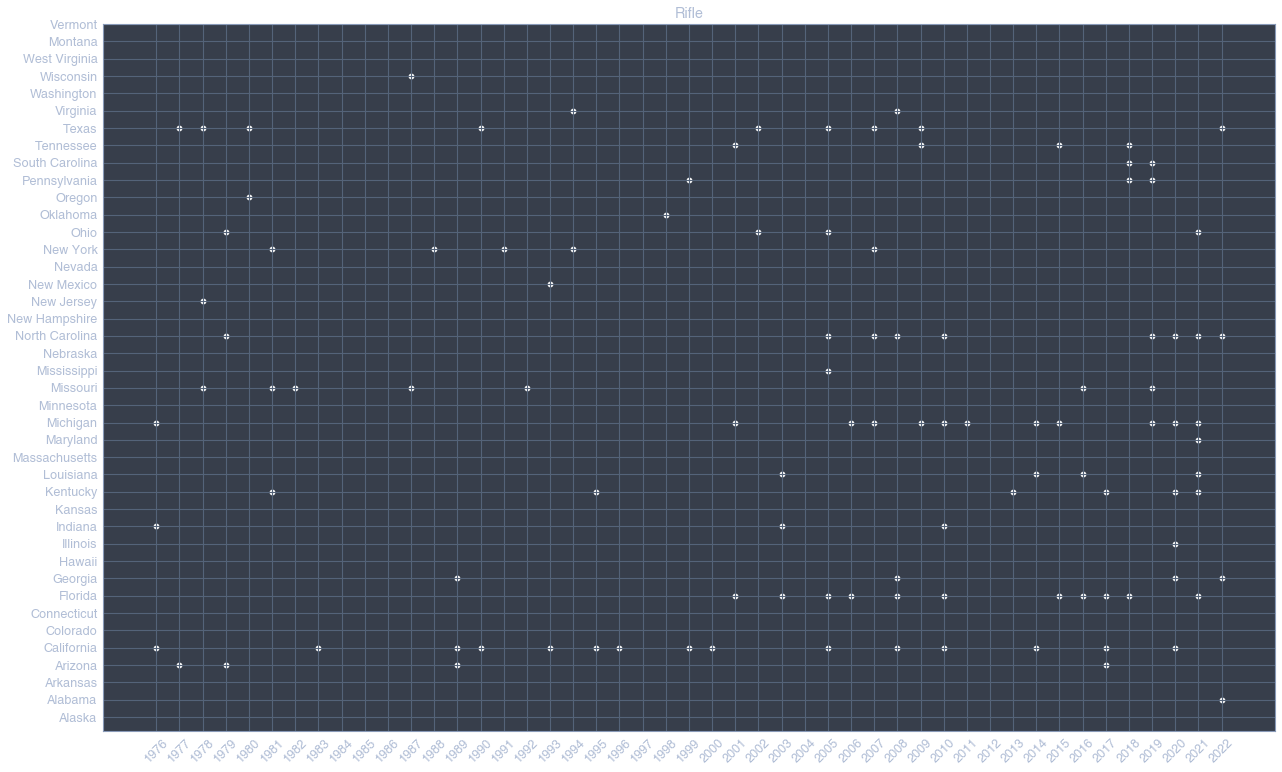

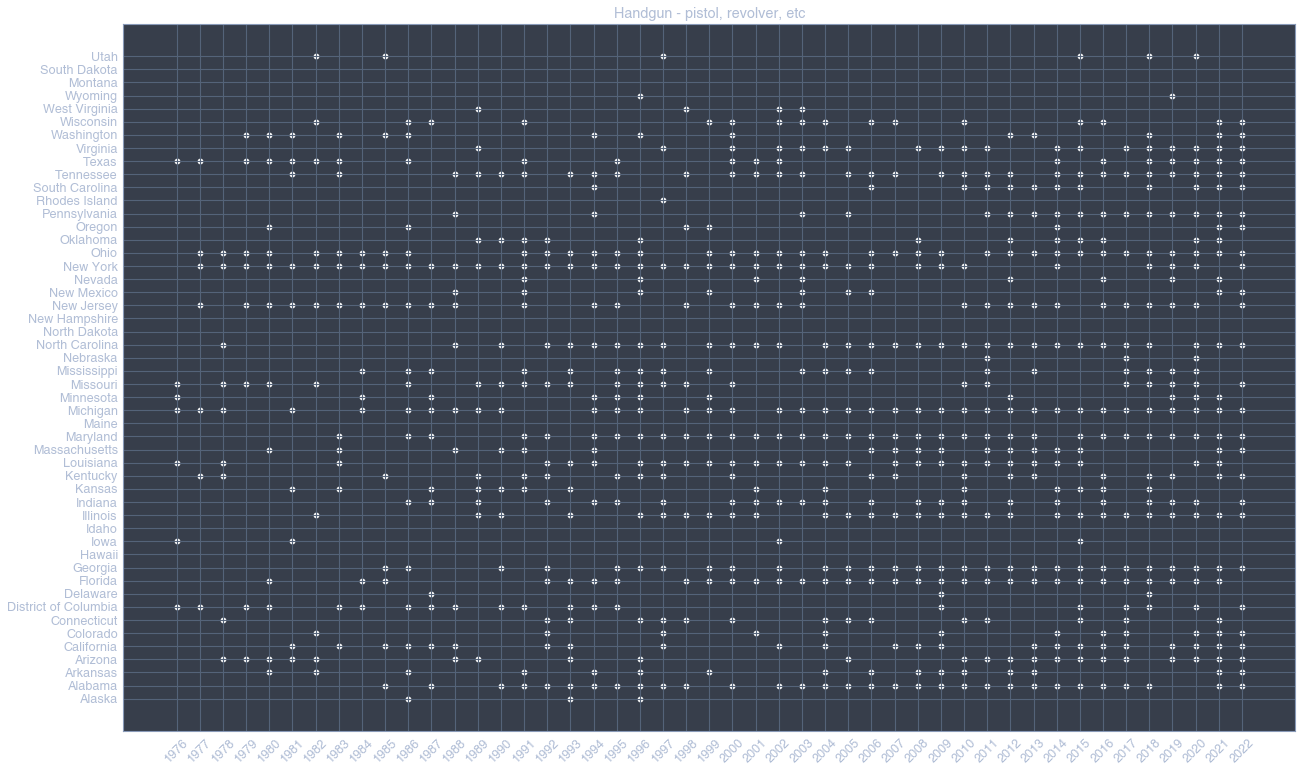

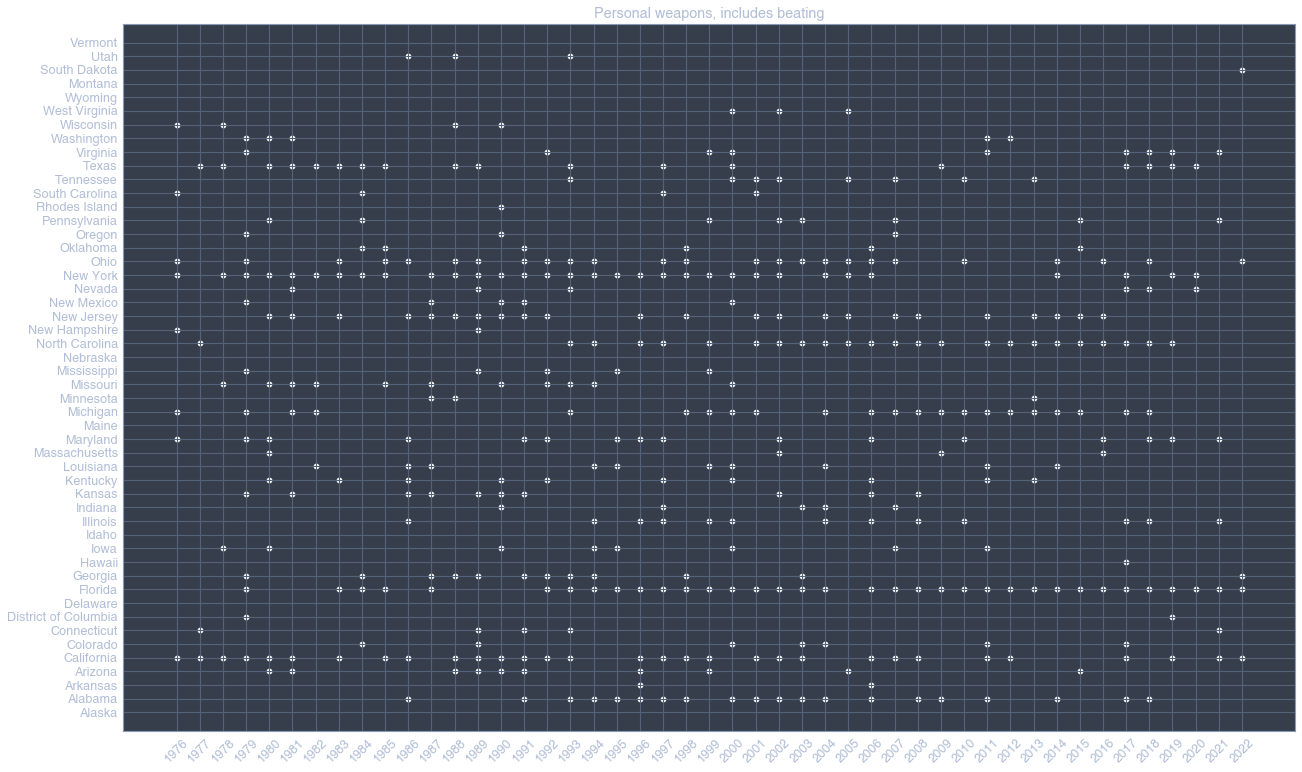

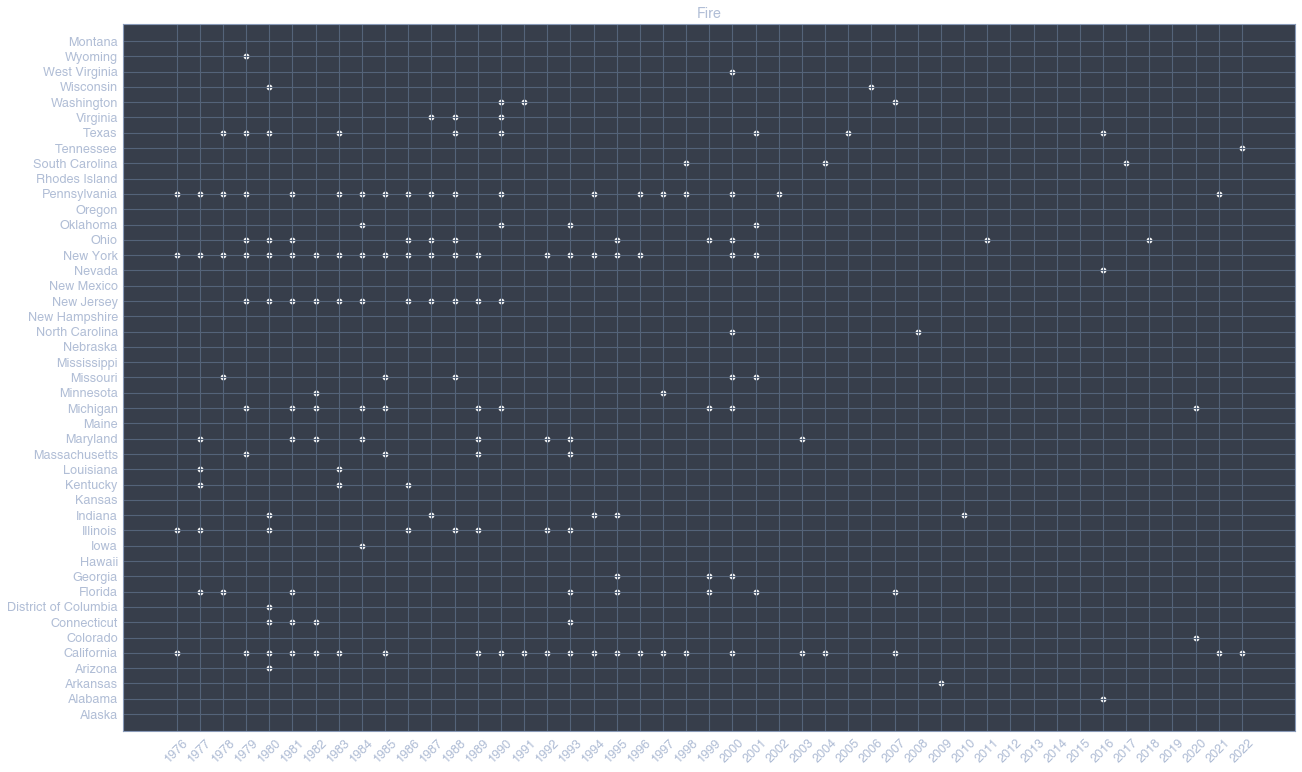

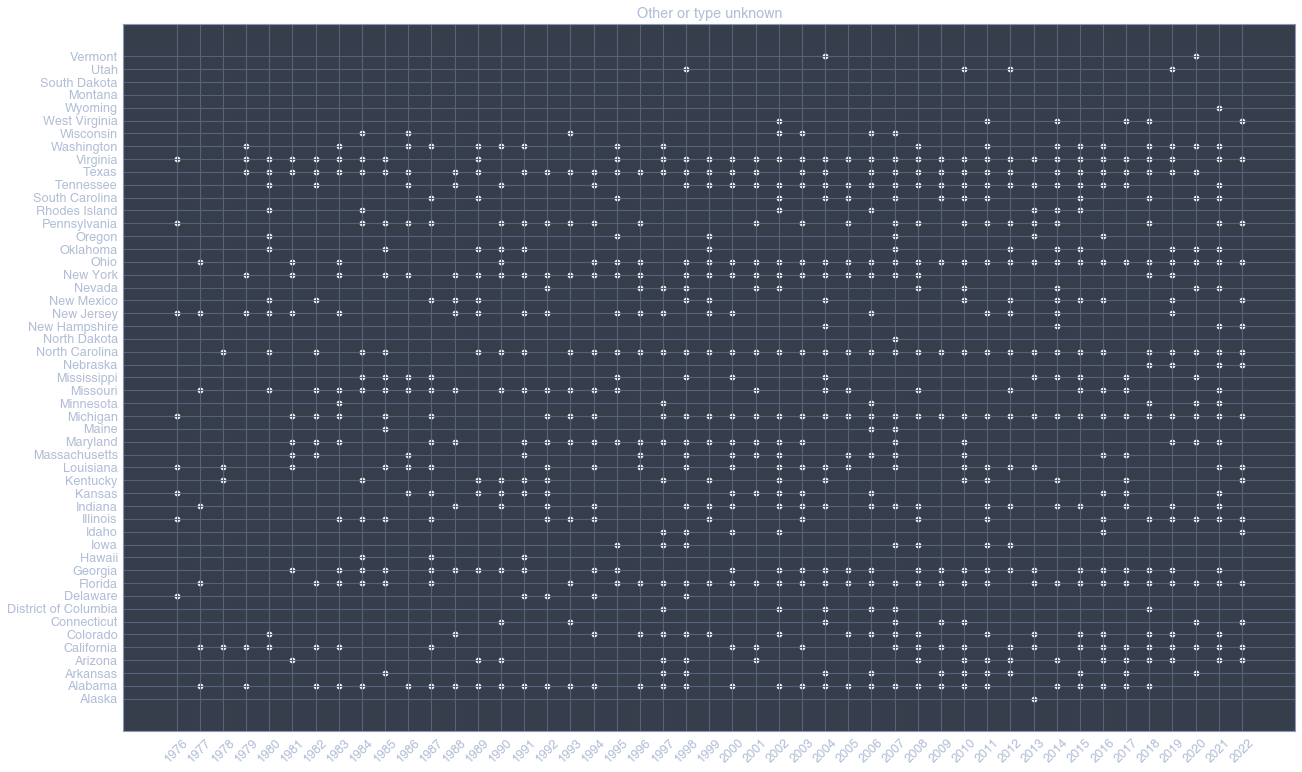

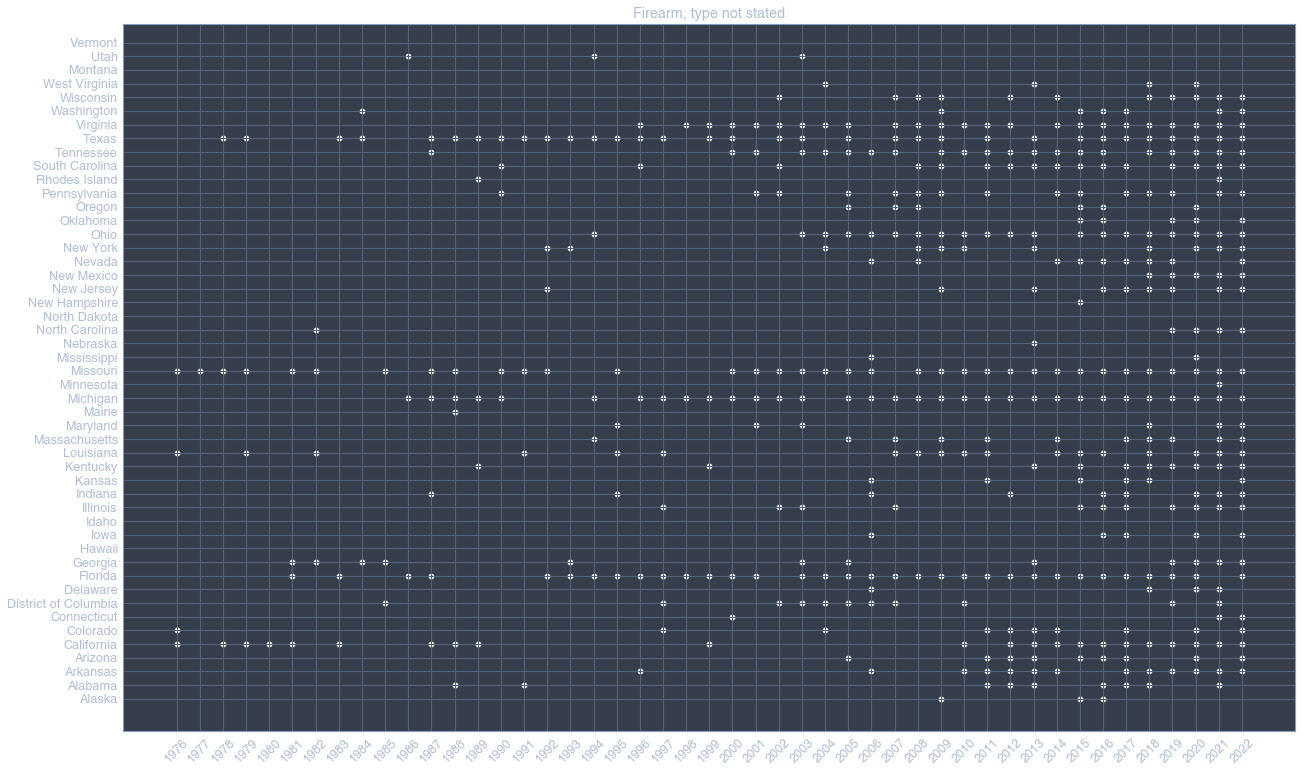

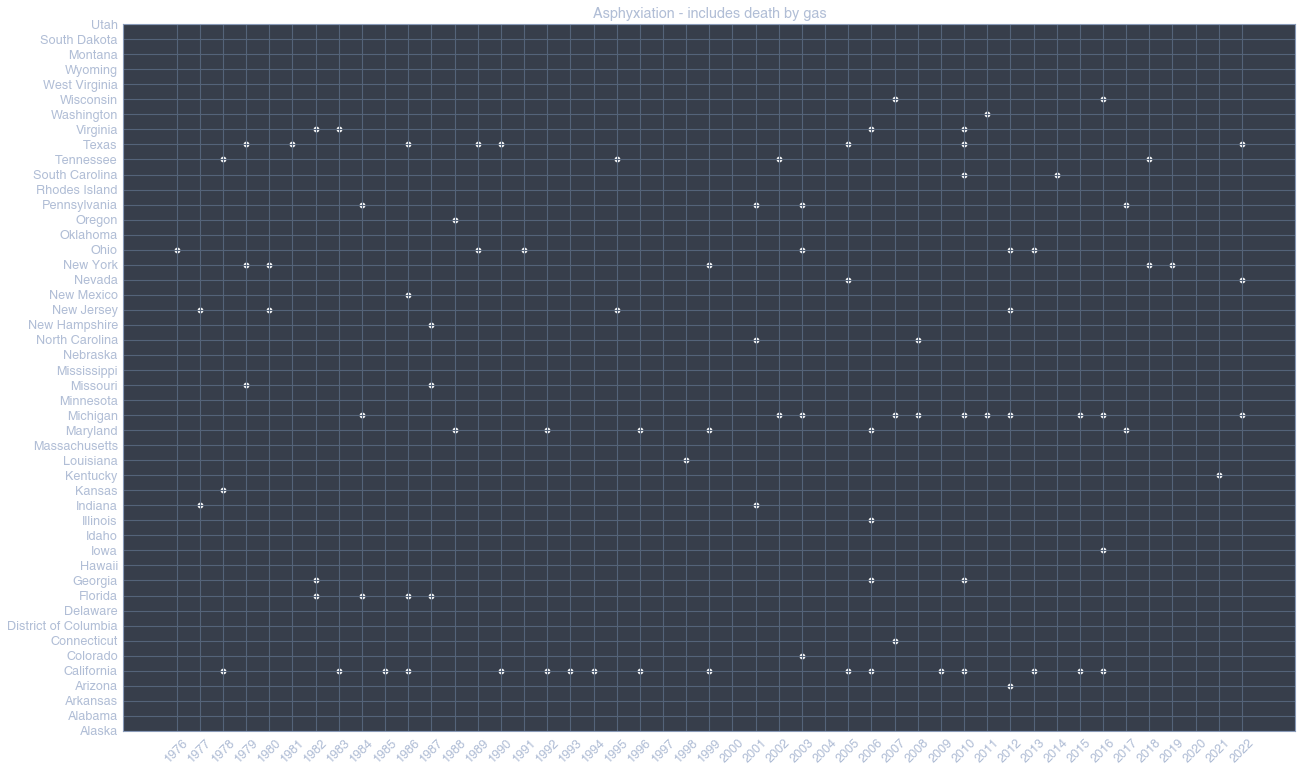

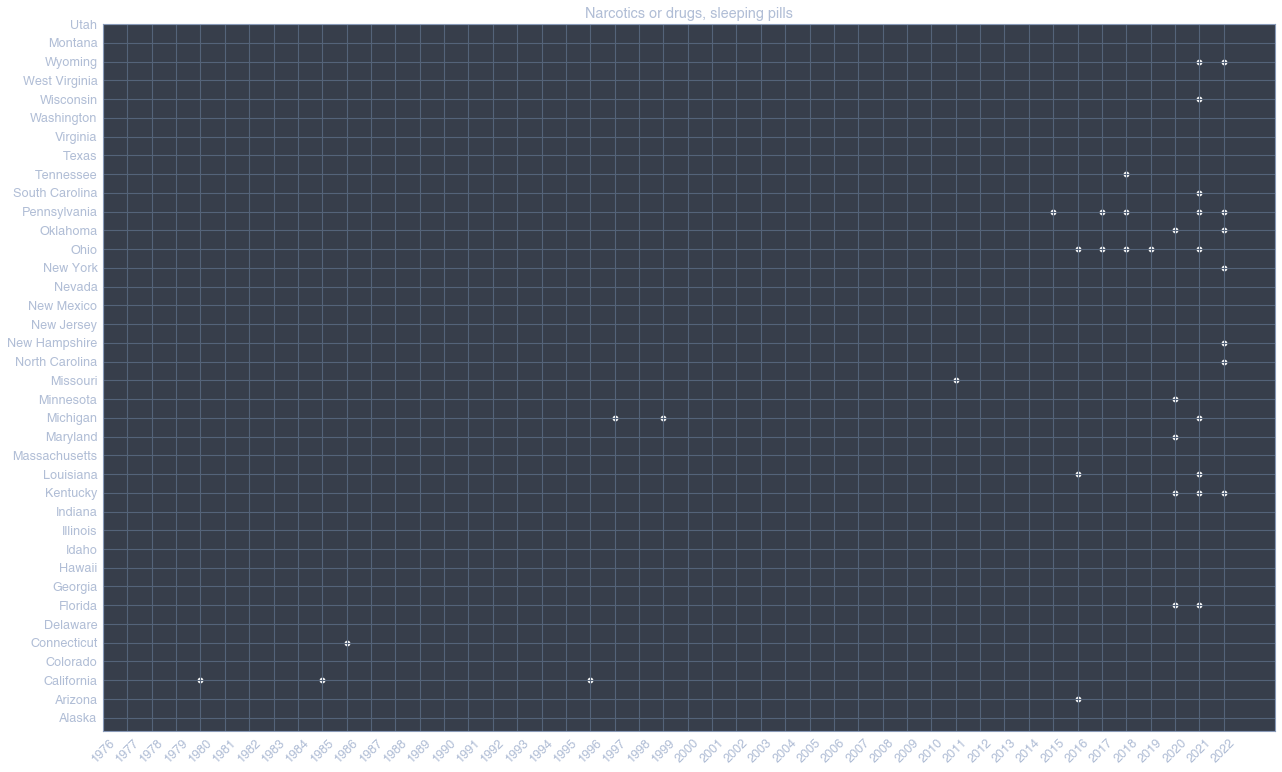

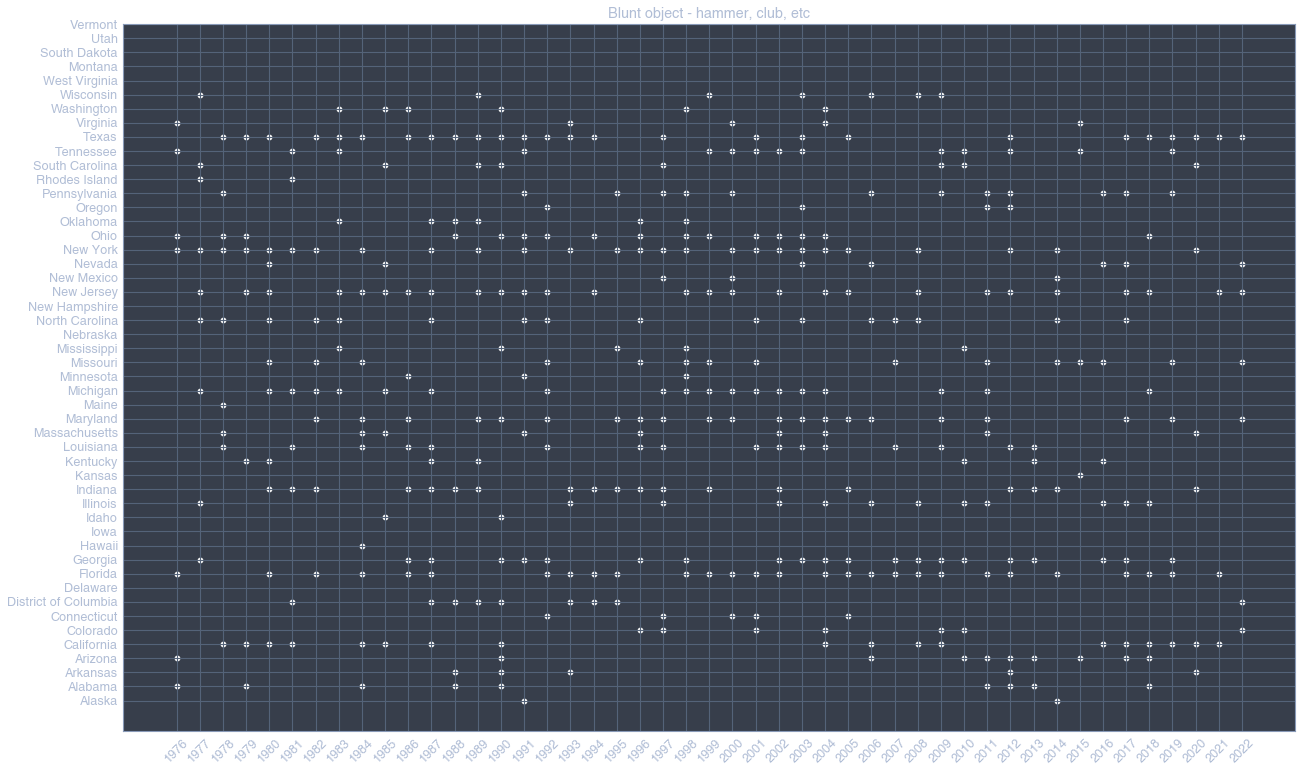

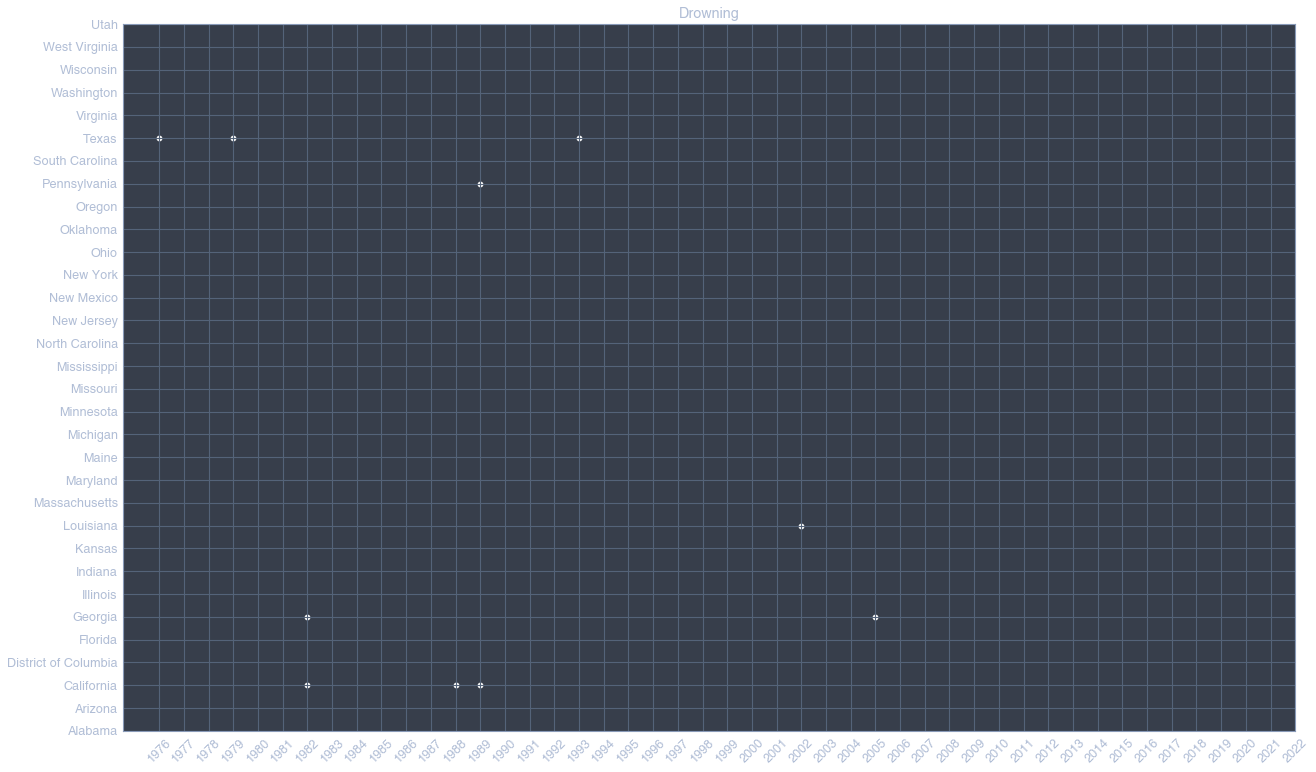

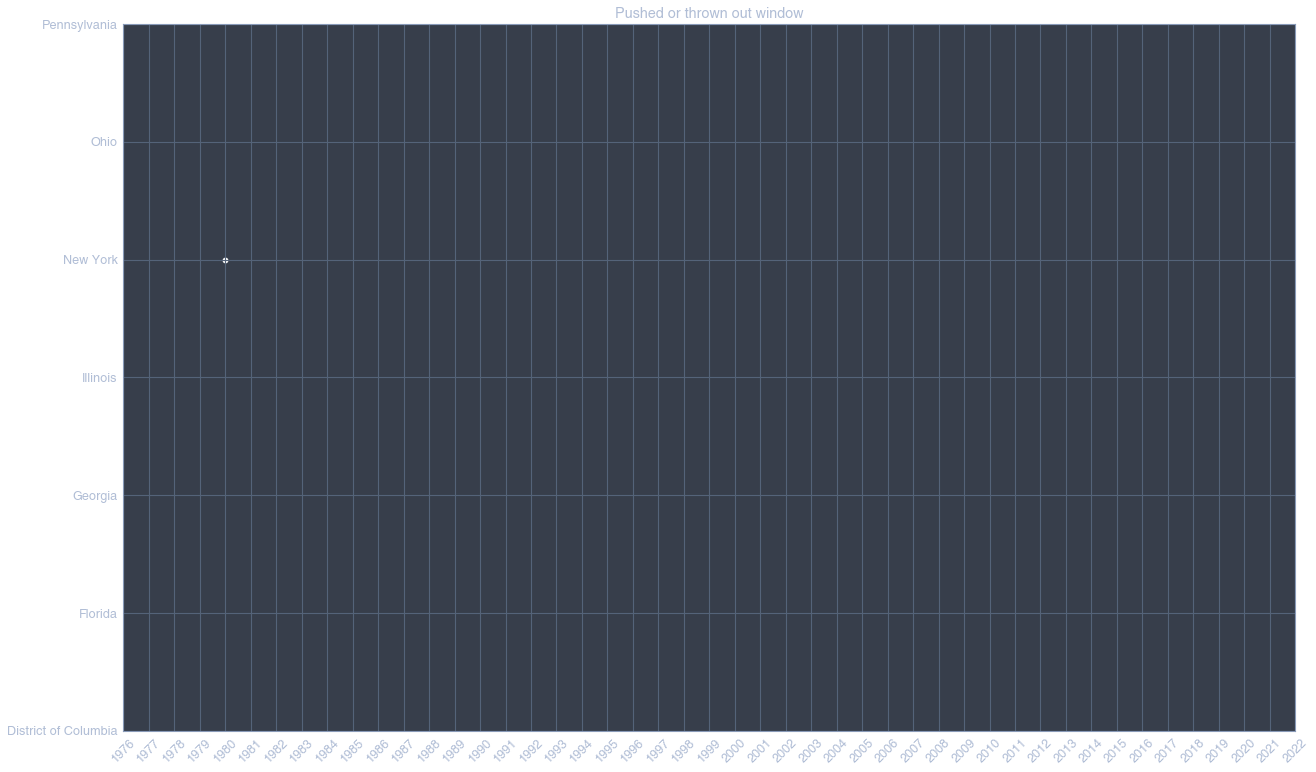

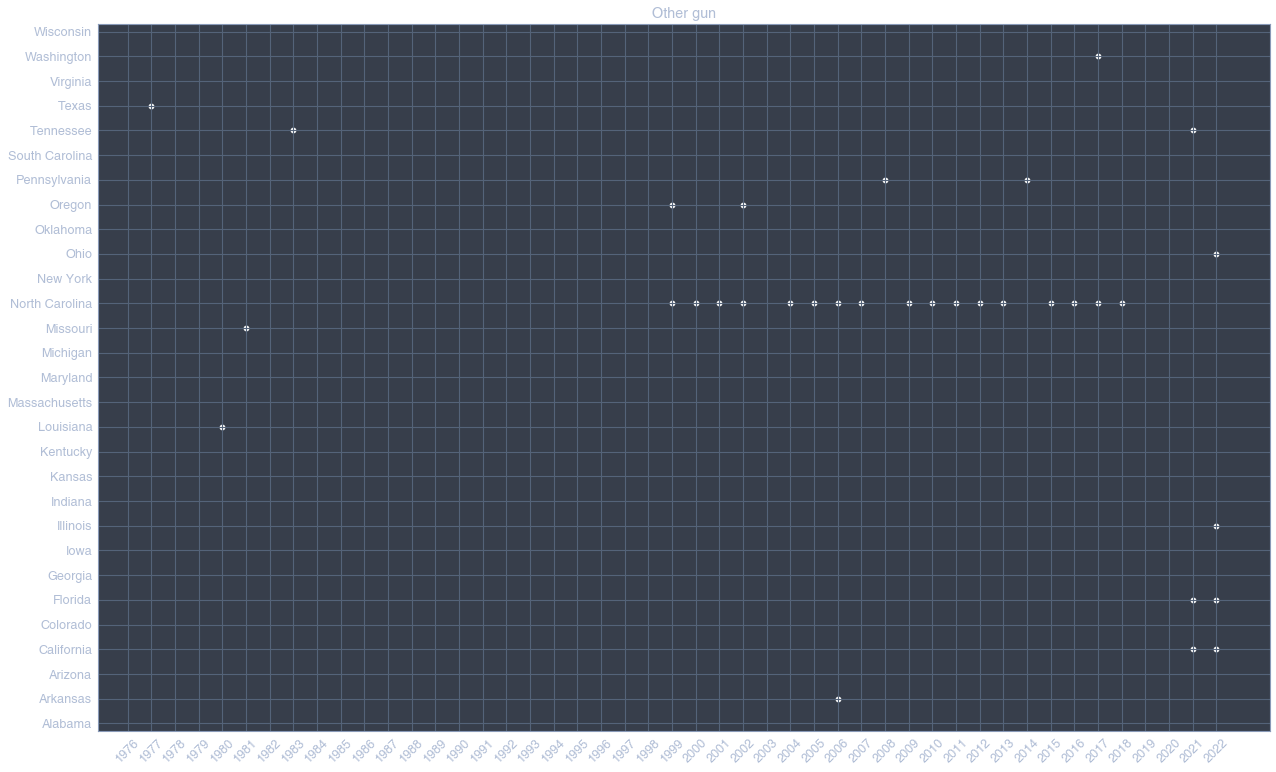

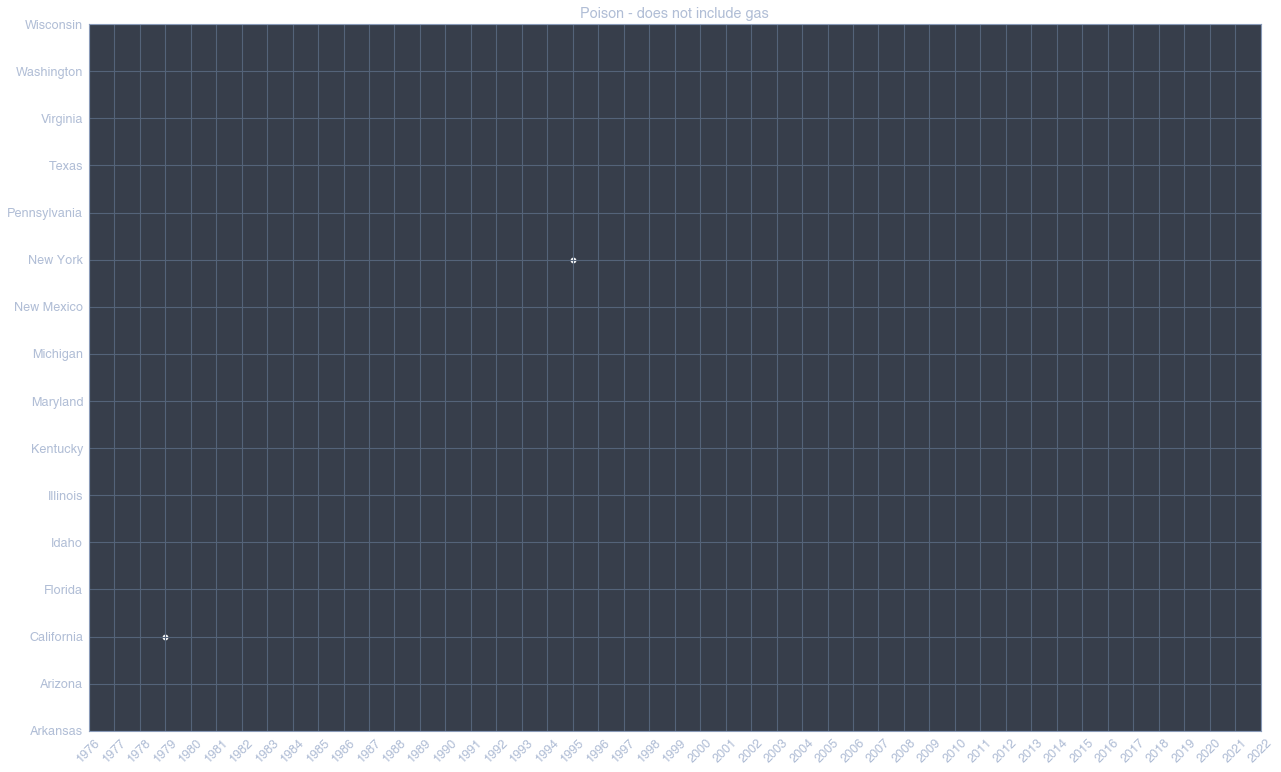

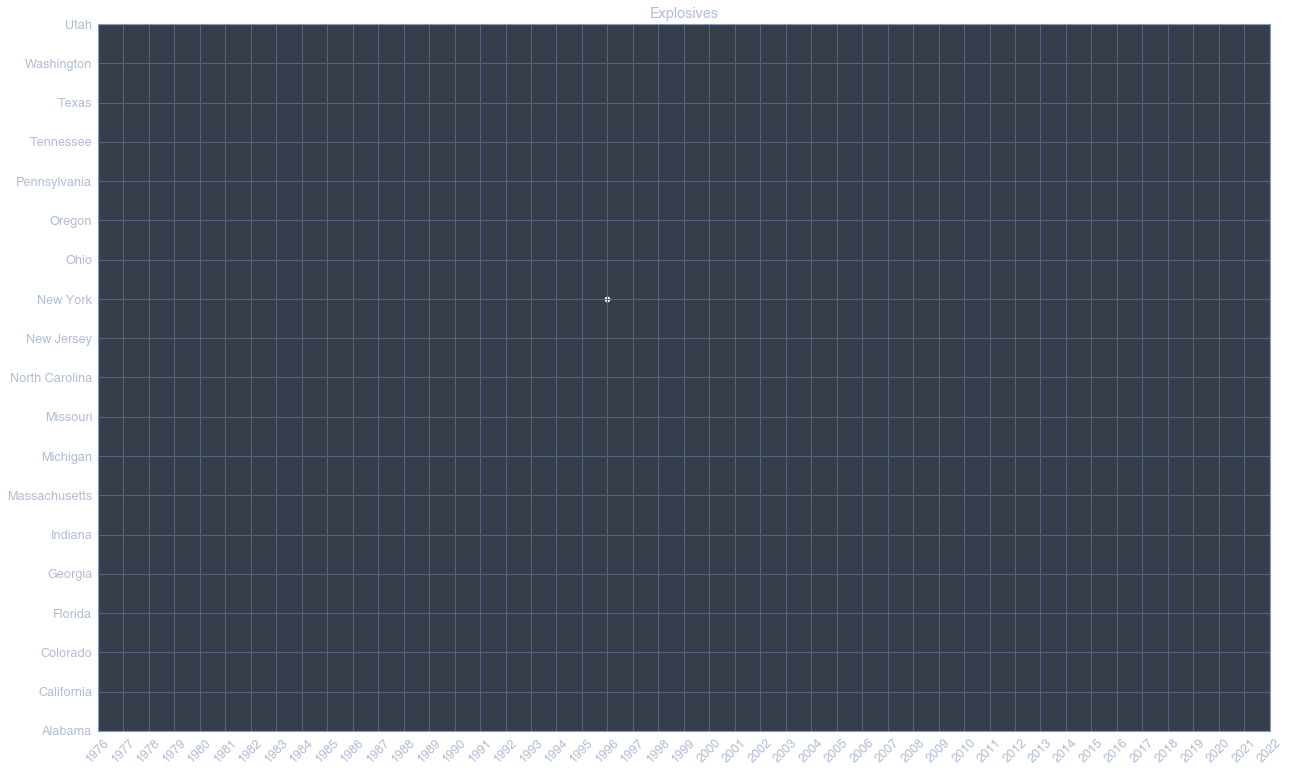

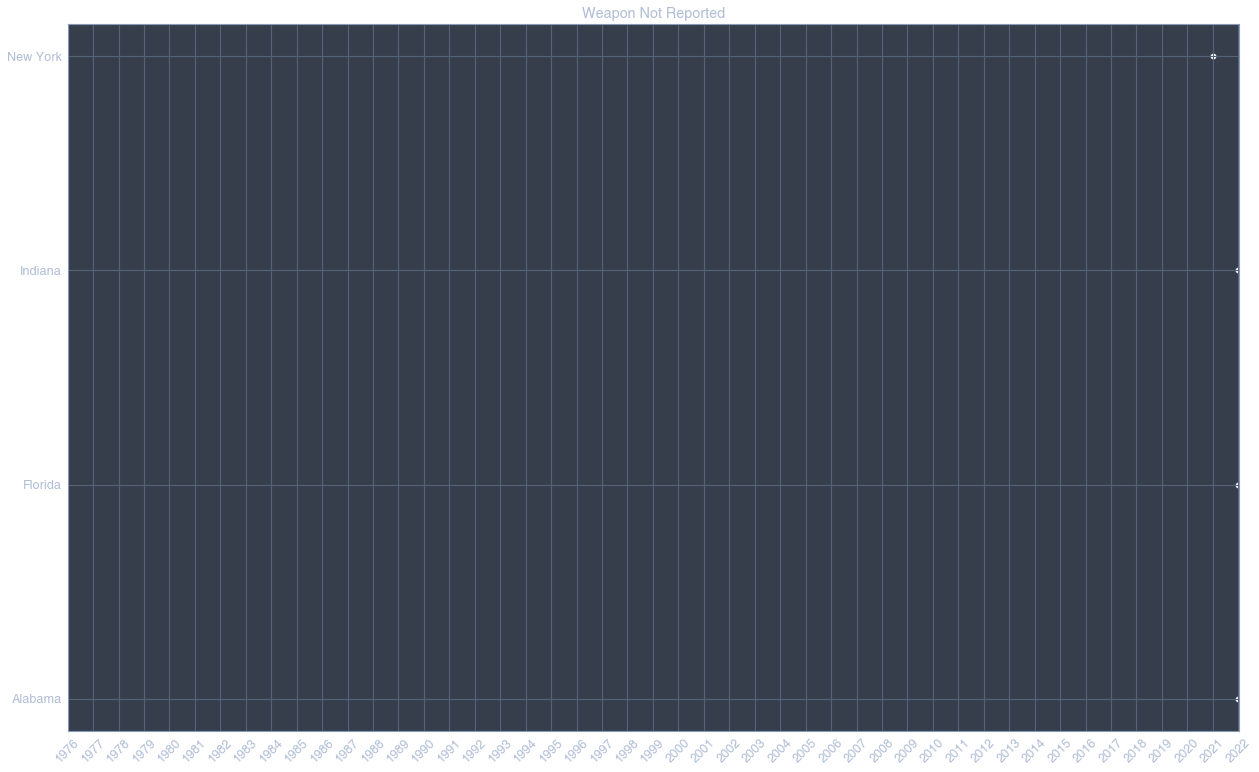

In [43]:
threshold = 0.35
x_labels = np.arange(1976, 2023)

for i, weapon in enumerate(weapons_df.keys()):
    weapon_df = weapons_df[weapon][weapons_df[weapon]<threshold]
    
    x = weapon_df.isnull().to_numpy().astype(int).T
    x = (x * np.tile(np.arange(1, weapon_df.index.shape[0]+1),
                     (weapon_df.columns.shape[0], 1))).flatten()
    y = np.repeat(np.arange(1, weapon_df.columns.shape[0]+1), 47)
    
    X = x[x!=0]
    Y = y[x!=0]

    y_labels = list(weapon_df.columns)
    
    plt.figure(figsize=(21,13))
    plt.scatter(X, Y, color='w')
    plt.yticks(np.arange(1, len(y_labels)+1), y_labels)
    plt.xticks(np.arange(1, 48), x_labels, rotation=45)
    plt.title(weapon);
    

In [ ]:
strangulation = {
    'Texas': [1976, 1981],
    'Maryland': [1992, 1998],
    'California': [[1976, 1987], [2013, 2020]],
    'Oregon': [1997, 2003]
}

fire = {
    'Pennsylvania': [1976, 1990],
    'New York': [[1976, 1989], [1992, 1996]],
    'New Jersey': [1979, 1990],
    'California': [1989, 1998]
}

oter_gun = {
    'North Carolina': [1998, 2018]
}